# Introduction
[Dataset Link](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)

From the author:

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Acknowledgements
(Confidential Source) - Use only for educational purposes If you use this dataset in your research, please credit the author.

## Study Context
You are a data analyst working for The Johns Hopkins Hospital. Your team is asked to create a machine learning model, which could predict if the patient is likely to get a stroke - being able to determine which patients have high stroke risk will allow your doctors to advise them and their families on how to act in case of an emergency.

The goal is to minimize unidentified stroke risk patients (recall) and minimize incorrect predictions of a patient being in a risk group (precision).

The performance metric for the study is the **positive class F1 score**.

## Summary
Using the Stacking Classifier method, the study combined Logistic Regression, Random Forest Classifier and XGBoost models to create a meta-model with the following performance scores:
* Positive F1 Score: 0.27
* Positive Precision: 0.17
* Positive Recall: 0.62
* The model identified two-thirds of stroke patients

Additionally, the model was deployed using Streamlit. The interactive application provides probabilities of a stroke risk.

# Data Preparation
## Modules, Functions Import & Configuration

In [ ]:
import os
import shap
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, f1_score, recall_score, precision_score

from utils import get_screen_width, get_color_palette, set_font_size
from utils import add_new_features, remove_columns, t_test, chi_squared_test
from utils import  visualize_performance, benchmark_models, draw_original_log_distribution
from utils import draw_numerical_plots, draw_categorical_plots, draw_predictor_target_plots
from utils import draw_boxplots, correlation_matrices

In [2]:
# Suppress Warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

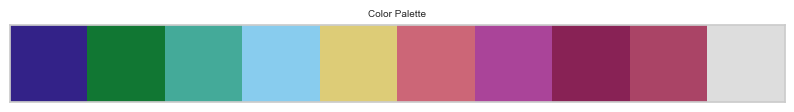

In [3]:
# Define random state, set visualization parameters
RANDOM_STATE = 98
fig_width = get_screen_width() / 100
font_sizes = set_font_size()
plt.rcParams.update(font_sizes)
pd.set_option('display.max_colwidth', None)
HTML('<style>{}</style>'.format(open('styles.css').read()))

# Color style
color_palette = get_color_palette()
sns.set_theme(font_scale=0.6)
sns.set_palette(color_palette)
sns.set_style('whitegrid', {'axes.grid' : False})
sns.palplot(color_palette)
plt.title('Color Palette')
plt.show()

## Dataset Import

In [4]:
DATA_PATH = 'data'
CSV_NAME = 'healthcare-dataset-stroke-data.csv'

df = pd.read_csv(os.path.join(DATA_PATH, CSV_NAME))

In [5]:
df = pd.read_csv(DATA_PATH+'/'+CSV_NAME)
df.head().T

,0,1,2,3,4
id,9046,51676,31112,60182,1665
gender,Male,Female,Male,Female,Female
age,67.0,61.0,80.0,49.0,79.0
hypertension,0,0,0,0,1
heart_disease,1,0,1,0,0
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.6,NaN,32.5,34.4,24.0


In [6]:
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset size: 5110 rows, 12 columns


# Data Formatting & Cleaning

In [7]:
df.columns = df.columns.str.lower()
df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)

In [8]:
def get_unique_values_summary(df):
    summary = []
    for col in df.columns:
        if df[col].dtype == 'object':
            unique_values = df[col].unique()
            summary.append({
                'Column': col,
                'Unique Values Count': len(unique_values),
                'Unique Values': unique_values
            })
    return pd.DataFrame(summary)


get_unique_values_summary(df)

,Column,Unique Values Count,Unique Values
0,gender,3,"[Male, Female, Other]"
1,ever_married,2,"[Yes, No]"
2,work_type,5,"[Private, Self-employed, Govt_job, children, Never_worked]"
3,residence_type,2,"[Urban, Rural]"
4,smoking_status,4,"[formerly smoked, never smoked, smokes, Unknown]"


In [9]:
duplicate_count = df.duplicated().sum()
print(f"Total rows: {len(df)}")
print(f"Duplicate rows: {duplicate_count}")
duplicates = df[df.duplicated(keep=False)]
sorted_duplicates = duplicates.sort_values(by=list(df.columns))
sorted_duplicates[:10] if len(duplicates) > 0 else None

Total rows: 5110
Duplicate rows: 0


<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>Medium-sized dataset of ~5000 rows, no duplicate values</ul>
        <ul>Data types match the contents as seen in <code>df.head()</code></ul>
        <ul>Imputation required for the <code>bmi</code> column as it has `null` values</ul>
        <ul>Mixed column data types (7 numeric, 5 categorical)</ul>
        <ul>3 numeric variables are binary</ul>
    </ol>
</div>

## Data Summary & Distribution
### Numerical Data

In [10]:
numerical_columns = df.drop('id', axis=1).select_dtypes(exclude='object').columns

In [11]:
round(df[numerical_columns].describe(exclude='object'), 2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.85,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.50,0.00
50%,45.00,0.0,0.00,91.88,28.10,0.00
75%,61.00,0.0,0.00,114.09,33.10,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


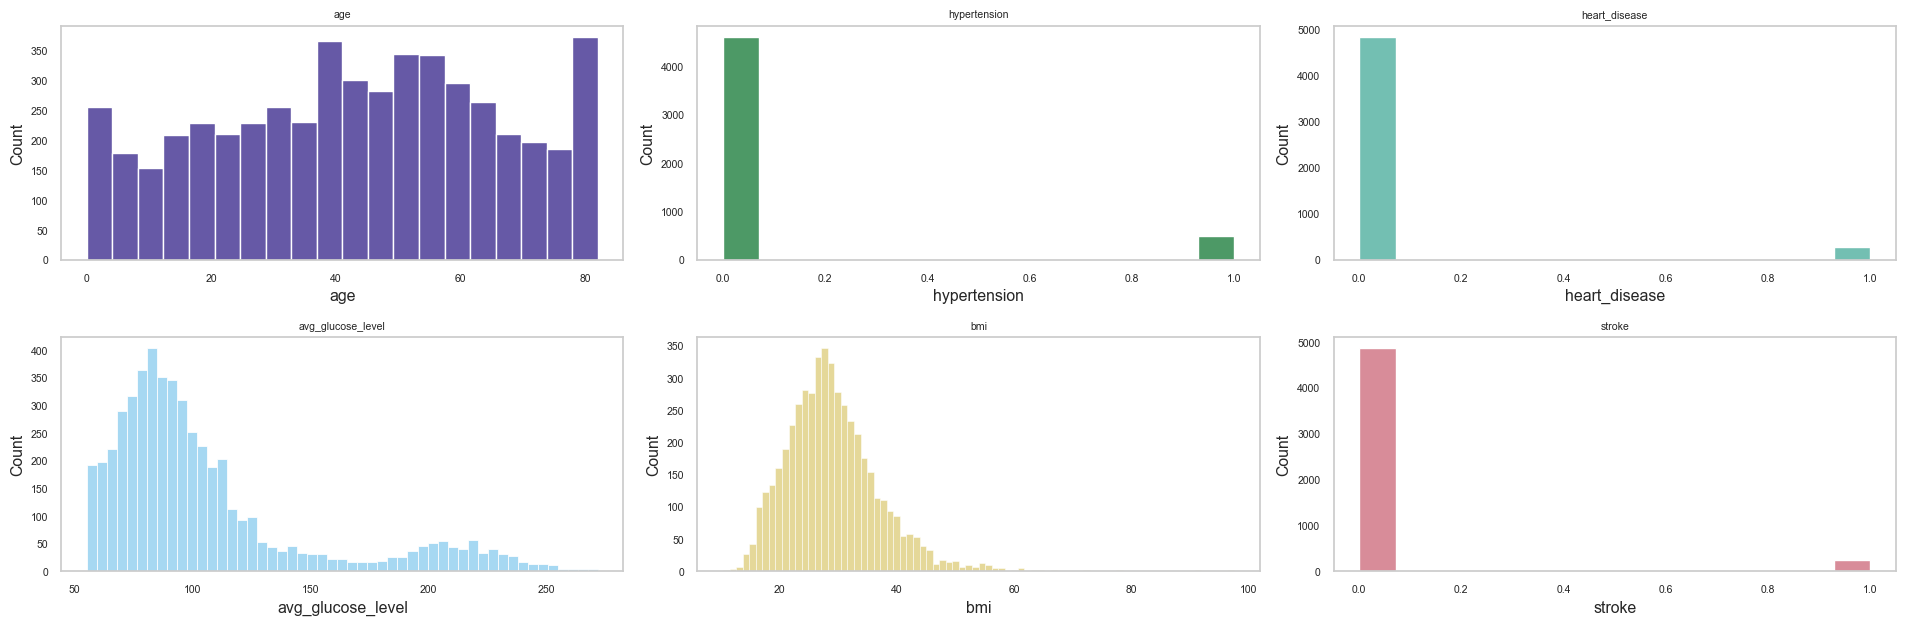

In [12]:
draw_numerical_plots(df, cols_list=numerical_columns, grid_cols=3)

## Categorical Data

In [13]:
categorical_columns = df.select_dtypes(include='object').columns

In [14]:
round(df.describe(include=['object']), 2)

,gender,ever_married,work_type,residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


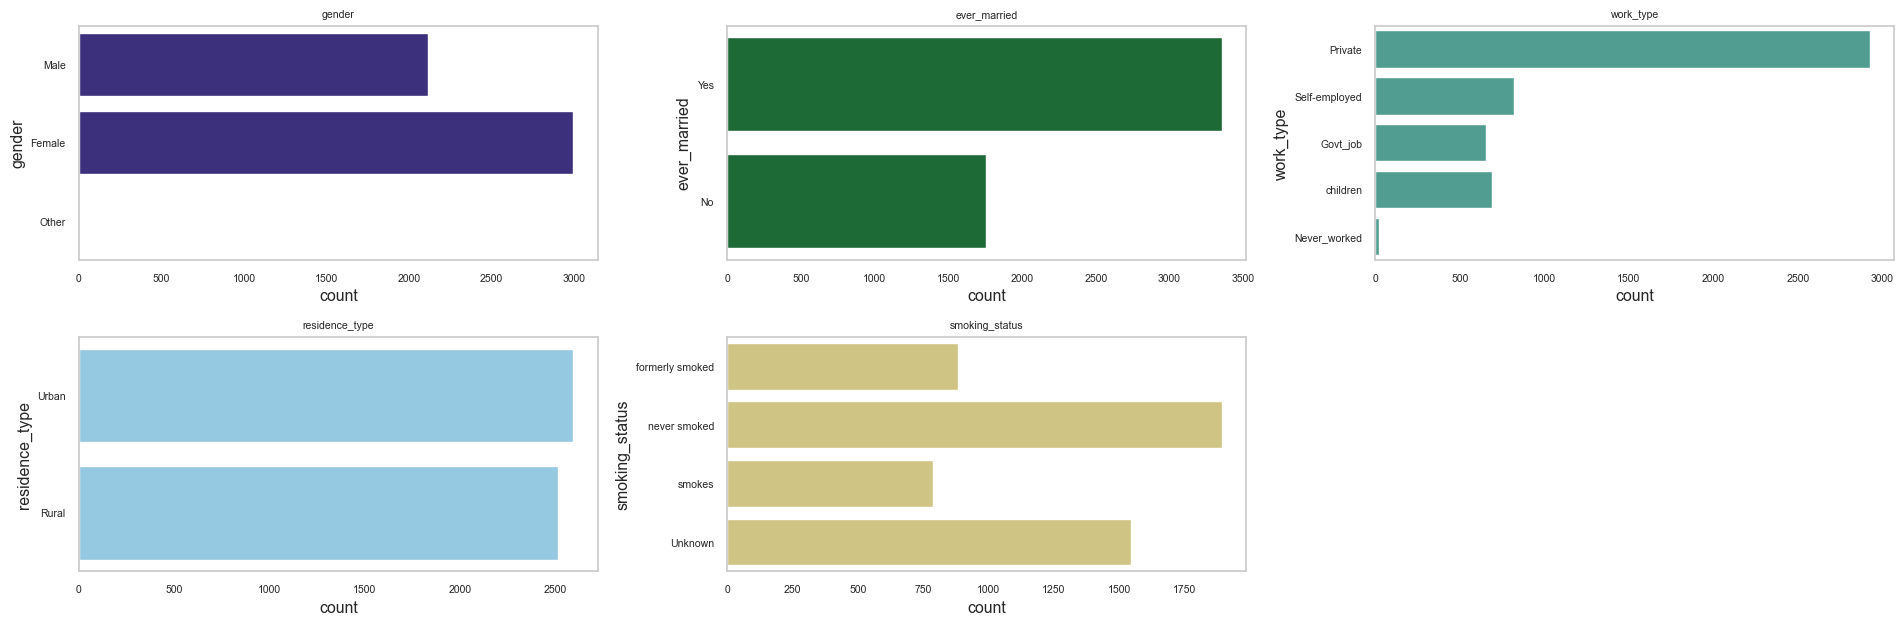

In [15]:
draw_categorical_plots(df, cols_list=categorical_columns, grid_cols=3)

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul><code>avg_glucose_level</code> and <code>bmi</code> have outliers; both are right-skewed</ul>
        <ul>Categorical columns don't have high cardinality; only two categories are outliers</ul>
    </ol>
</div>

# Exploratory Data Analysis
For some statistical significance & correlation tests, we will need a complete dataset without any missing values. We will impute the mean / most frequent value for numeric and categorical values respectively. In our case, only `bmi` will require imputing.

In [16]:
df_imputed = df.copy()
df_imputed[numerical_columns] = SimpleImputer(strategy='mean').fit_transform(df[numerical_columns])
df_imputed[categorical_columns] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_columns])

## Target variable

In [17]:
value_counts = df['stroke'].value_counts()
percentage_of_total = round((value_counts / value_counts.sum()) * 100, 2)
result = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total (%)': percentage_of_total
})
result

,Value Counts,Percentage of Total (%)
stroke,,
0,4861,95.13
1,249,4.87


Less than 5% of the subjects in the dataset had a stroke. We will experiment with class weights during model training.

## Numerical predictors
### Age

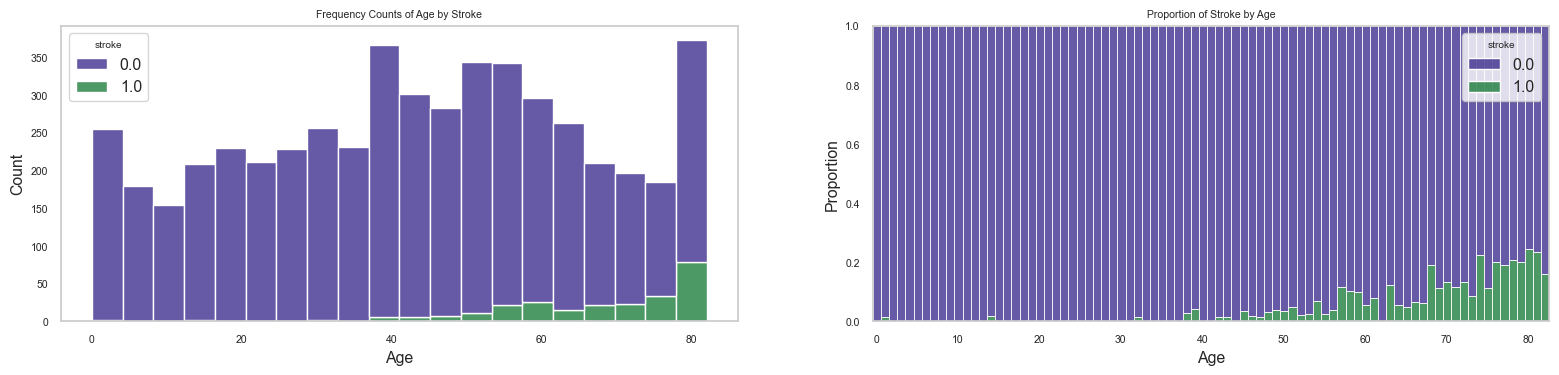

T-statistic: 18.08
P-value: 0.000000
Mean age of stroke group: 67.73
Mean age of non-stroke group: 41.97


In [18]:
draw_predictor_target_plots(df_imputed, predictor='age', target='stroke')
t_test(df_imputed, predictor='age', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Age and Stroke</p>
    <ol>
        <ul>Strokes were more frequent at older age, ramping up from 40 years old</ul>
        <ul>From around age 75, about 20% of patients in the dataset suffered from a stroke</ul>
        <ul>There is a statistically significant difference in age between stroke and non-stroke patients</ul>
    </ol>
</div>

### Body Mass Index (BMI)

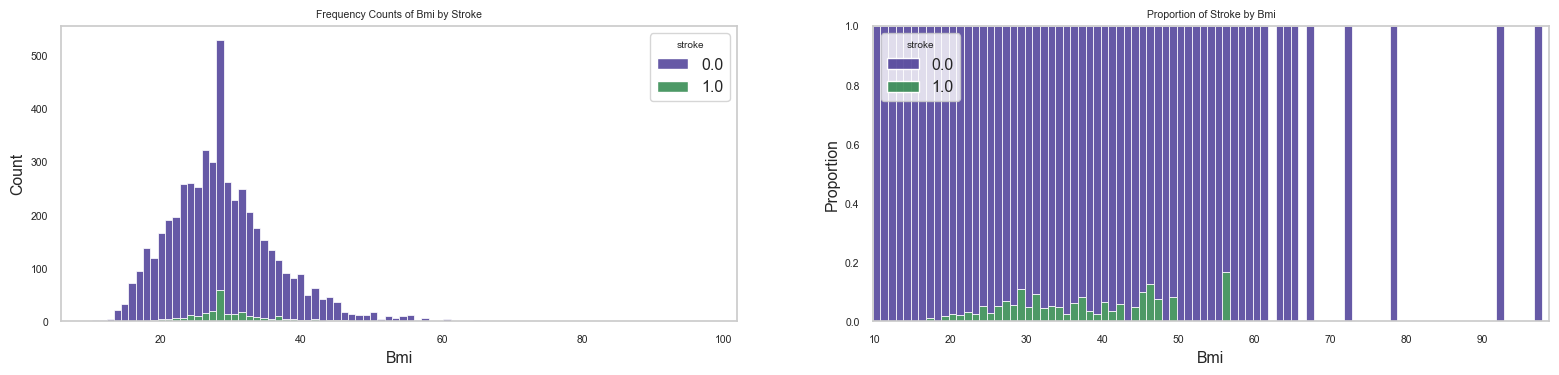

T-statistic: 2.79
P-value: 0.005362
Mean bmi of stroke group: 30.22
Mean bmi of non-stroke group: 28.83


In [19]:
draw_predictor_target_plots(df_imputed, predictor='bmi', target='stroke')
t_test(df_imputed, predictor='bmi', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>BMI and Stroke</p>
    <ol>
        <ul>Strokes were mostly recorded within the BMI range from 20 to 40 and resemble the shape of the distribution itself</ul>
        <ul>Proportionally, the risk of stroke seemed to show an upward trend with higher BMI</ul>
        <ul>Although not wide, there is a statistically significant difference in BMI between stroke and non-stroke patients</ul>
        <ul>The tall bar in the frequency chart represents the imputed mean</ul>
    </ol>
</div>

### Average Glucose

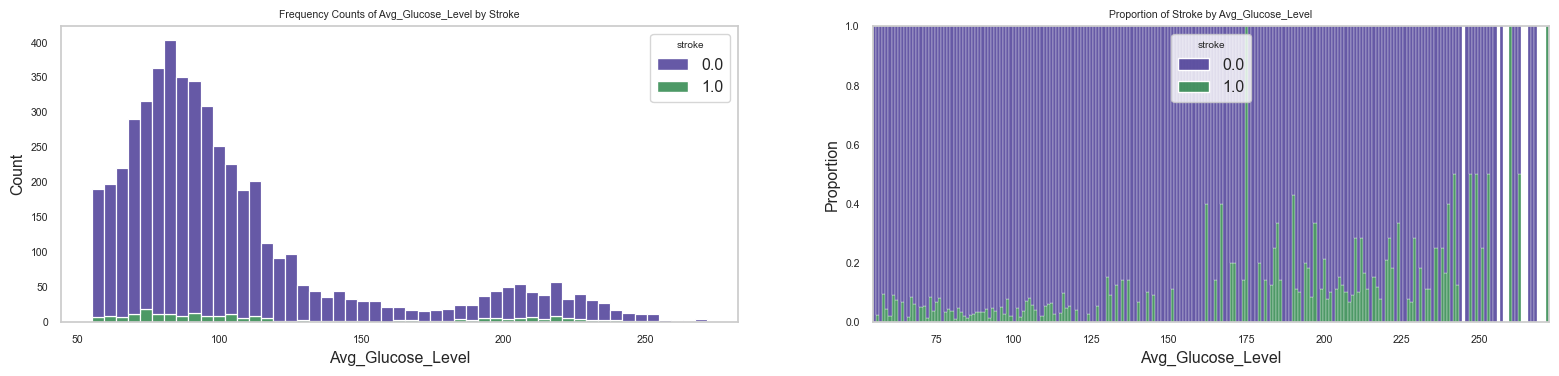

T-statistic: 9.51
P-value: 0.000000
Mean avg_glucose_level of stroke group: 132.54
Mean avg_glucose_level of non-stroke group: 104.80


In [20]:
draw_predictor_target_plots(df_imputed, predictor='avg_glucose_level', target='stroke')
t_test(df_imputed, predictor='avg_glucose_level', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Glucose Levels and Stroke</p>
    <ol>
        <ul>The distribution is bimodal, with a smaller group of patients having higher glucose levels</ul>
        <ul>Proportionally, the risk of stroke seemed to be higher for high glucose levels. Some groups with 240+ blood glucose had 50% or 100% stroke rates</ul>
        <ul>There is a statistically significant difference in blood glucose level between stroke and non-stroke patients</ul>
    </ol>
</div>

### Hypertension

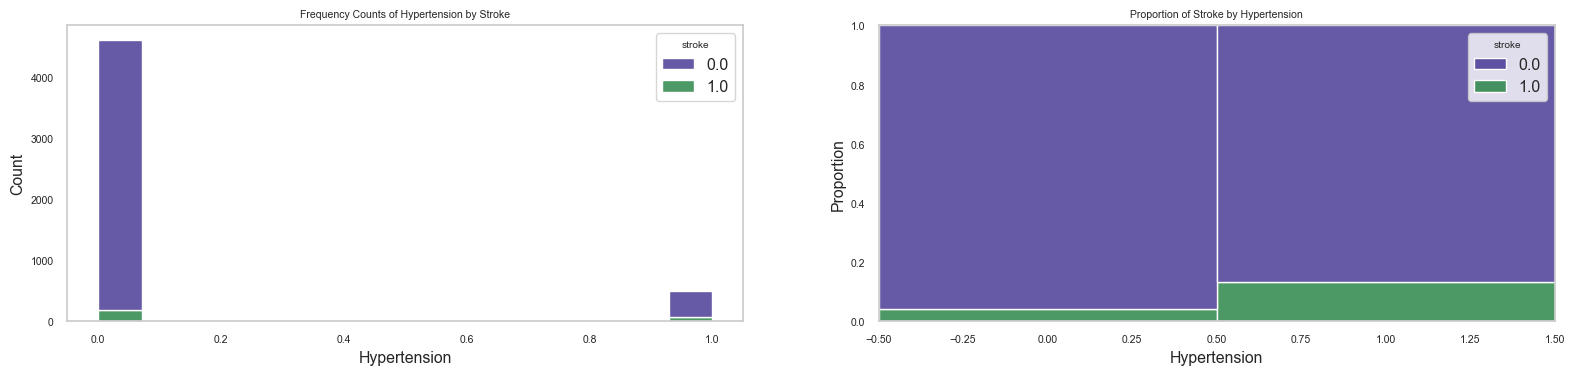

T-statistic: 9.22
P-value: 0.000000
Mean hypertension of stroke group: 0.27
Mean hypertension of non-stroke group: 0.09


In [21]:
draw_predictor_target_plots(df_imputed, predictor='hypertension', target='stroke')
t_test(df_imputed, predictor='hypertension', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Hypertension and Stroke</p>
    <ol>
        <ul>There are much less patients with hypertension</ul>
        <ul>Proportionally, more than 15% of patients with hypertension had a stroke</ul>
        <ul>Based on the mean of the two groups, the stroke group was more likely to have hypertension</ul>
    </ol>
</div>

### Heart Disease

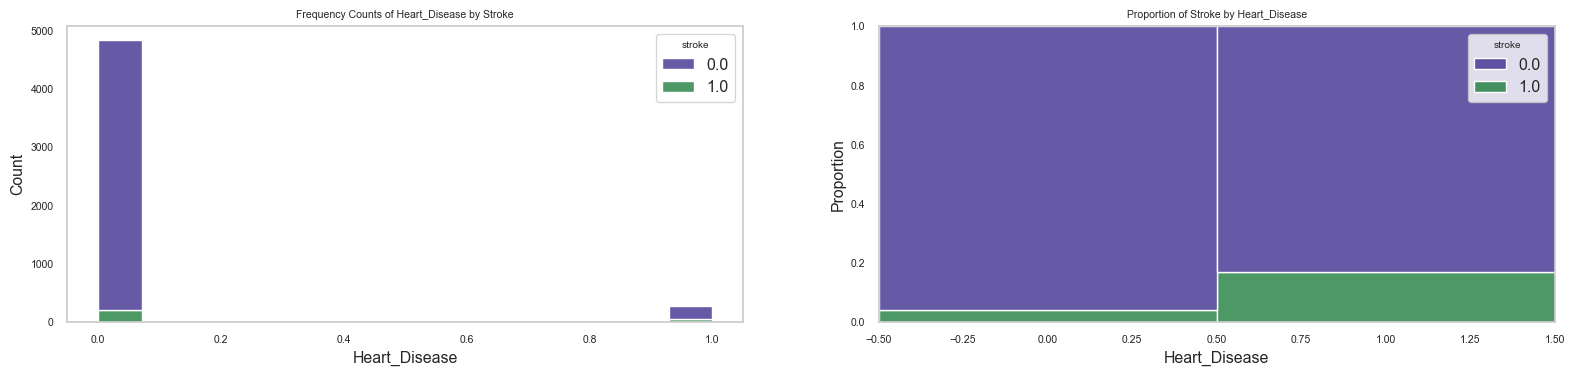

T-statistic: 9.73
P-value: 0.000000
Mean heart_disease of stroke group: 0.19
Mean heart_disease of non-stroke group: 0.05


In [22]:
draw_predictor_target_plots(df_imputed, predictor='heart_disease', target='stroke')
t_test(df_imputed, predictor='heart_disease', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Heart Disease and Stroke</p>
    <ol>
        <ul>There are much less patients with heart disease</ul>
        <ul>Proportionally, about 20% of patients with heart disease had a stroke</ul>
        <ul>Based on the mean of the two groups, the stroke group was more likely to have a heart disease</ul>
    </ol>
</div>

### Bivariate Analysis

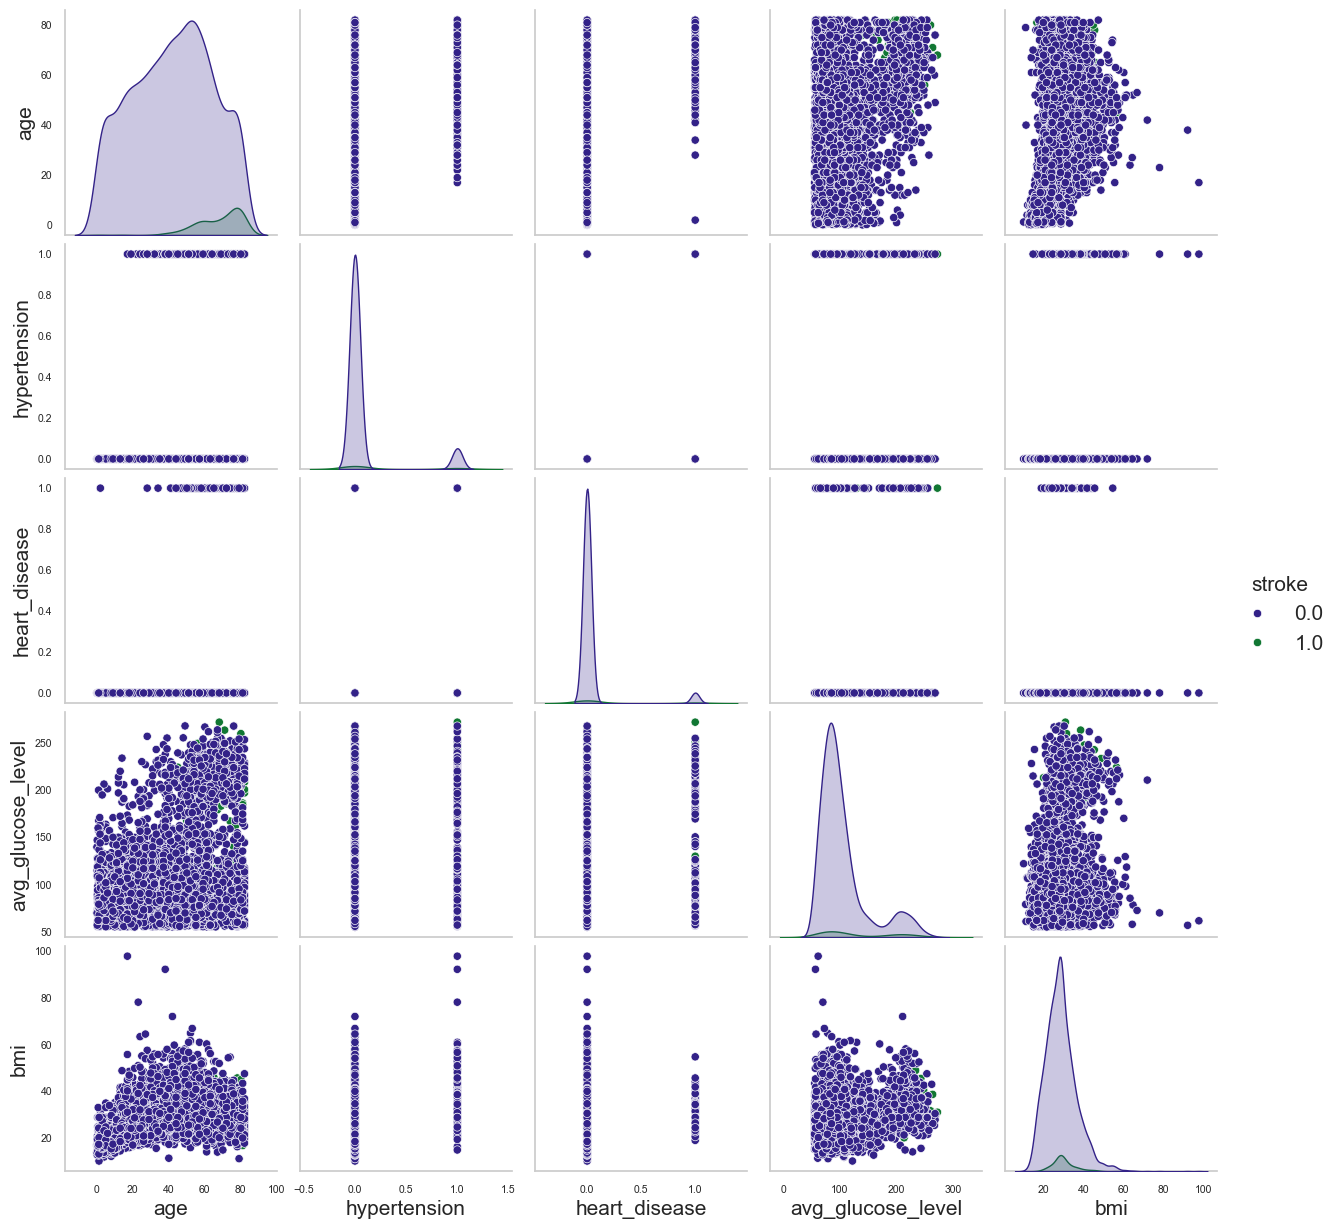

In [23]:
with sns.plotting_context(font_scale=1.5, rc={"axes.titlesize": 20, "axes.labelsize": 15,
                                              "legend.fontsize": 15, "legend.title_fontsize": 15}):
    sns.pairplot(df_imputed[numerical_columns], hue='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Bivariate Numeric Feature Analysis</p>
    <ol>
        <ul>Hypertension, Heart disease and glucose levels seem to increase with age. BMI is the largest between ages 25-50</ul>
        <ul>Surprisingly, patients with highest BMI scores do not have large average glucose levels</ul>
    </ol>
</div>

## Categorical Predictors
### Gender

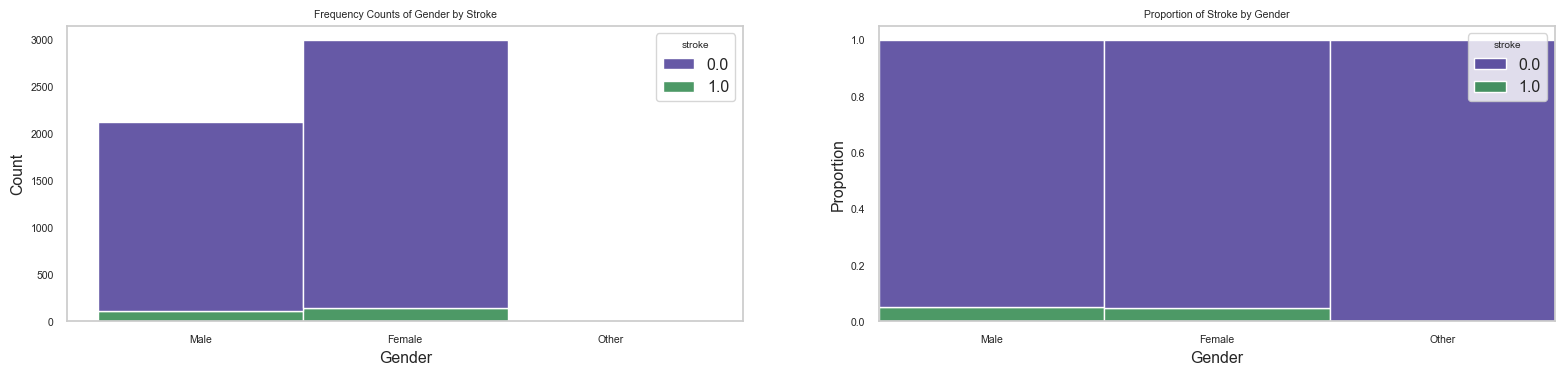

Chi-squared Statistic: 0.4726
P-value: 0.789549


In [24]:
draw_predictor_target_plots(df_imputed, predictor='gender', target='stroke')
chi_squared_test(df_imputed, predictor='gender', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Gender and Stroke</p>
    <ol>
        <ul>There are more female patients in the dataset, yet the proportions remain very similar</ul>
        <ul>The "Other" gender does not have many instances or cases of strokes</ul>
        <ul>The p-value provides evidence that gender is not a statistically significant feature when differentiating between stroke and non-stroke patients</ul>
    </ol>
</div>

### Marriage Status

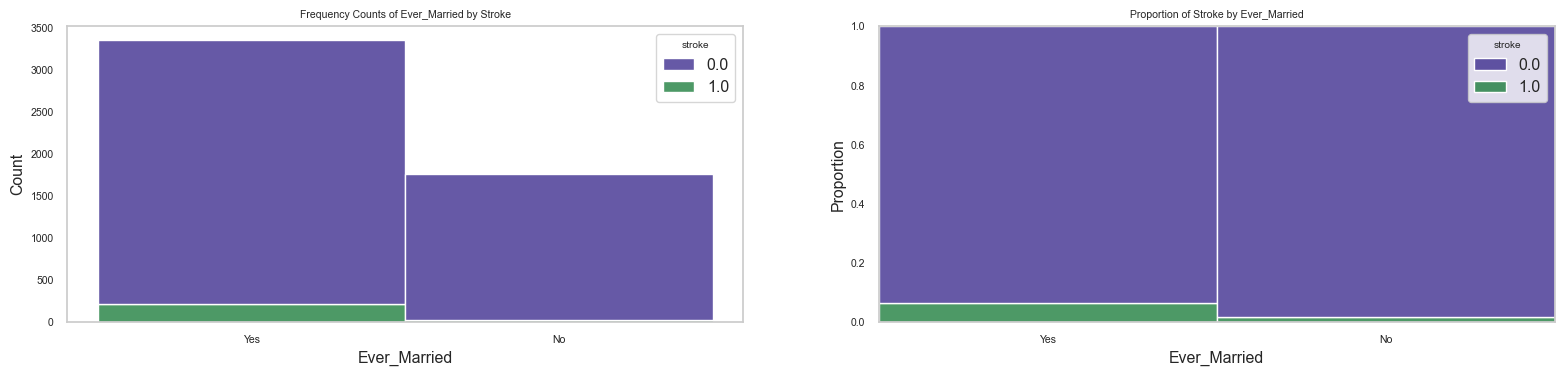

Chi-squared Statistic: 58.9239
P-value: 0.000000


In [25]:
draw_predictor_target_plots(df_imputed, predictor='ever_married', target='stroke')
chi_squared_test(df_imputed, predictor='ever_married', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Marriage Status and Stroke</p>
    <ol>
        <ul>There are twice as many married patients in the dataset</ul>
        <ul>Similarly, married patients in the dataset seemed to have thrice as much stroke cases</ul>
        <ul>The p-value provides evidence that marriage is a statistically significant feature</ul>
    </ol>
</div>

### Work Type

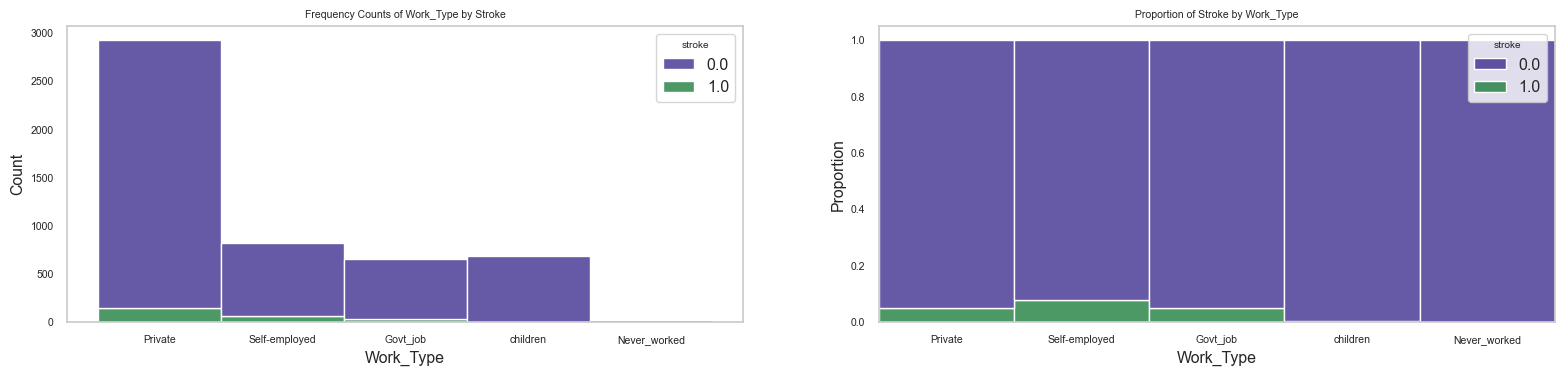

Chi-squared Statistic: 49.1635
P-value: 0.000000


In [26]:
draw_predictor_target_plots(df_imputed, predictor='work_type', target='stroke')
chi_squared_test(df_imputed, predictor='work_type', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Work Type and Stroke</p>
    <ol>
        <ul>Work in the private sector is the most prevalent category in the dataset</ul>
        <ul>Proportionally, self-employed individuals were the most likely to suffer a stroke; Private and Government employees shared a similar proportion</ul>
        <ul>The p-value provides evidence that work type is a statistically significant feature</ul>
    </ol>
</div>

### Residence Type

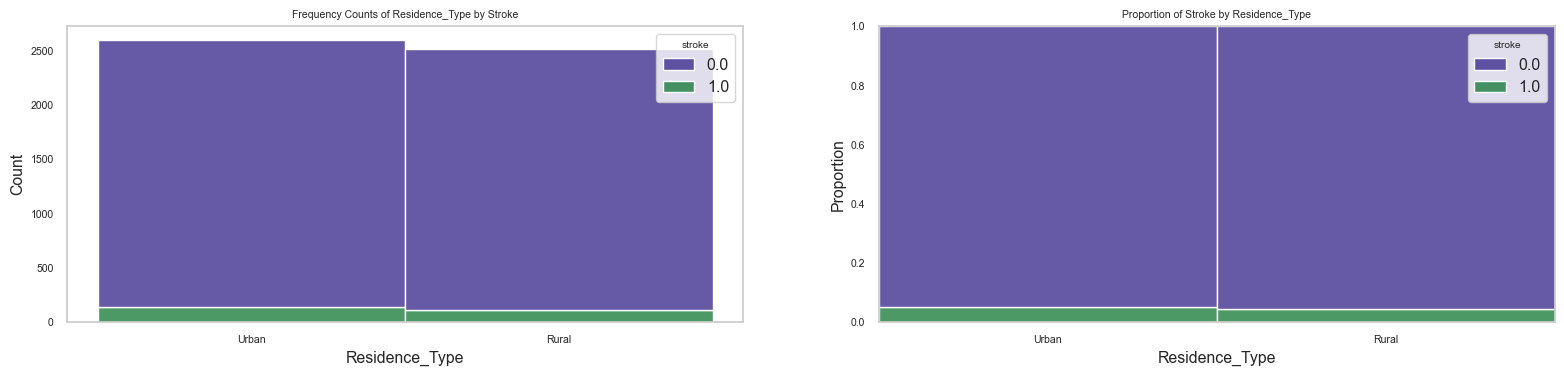

Chi-squared Statistic: 1.0816
P-value: 0.298332


In [27]:
draw_predictor_target_plots(df_imputed, predictor='residence_type', target='stroke')
chi_squared_test(df_imputed, predictor='residence_type', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Residence Type and Stroke</p>
    <ol>
        <ul>The dataset has an almost equal split of Urban and Rural residence patients</ul>
        <ul>Proportionally, both classes are very similar.</ul>
        <ul>The p-value does not provide strong enough evidence that residence type is a statistically significant feature</ul>
    </ol>
</div>

### Smoking Status

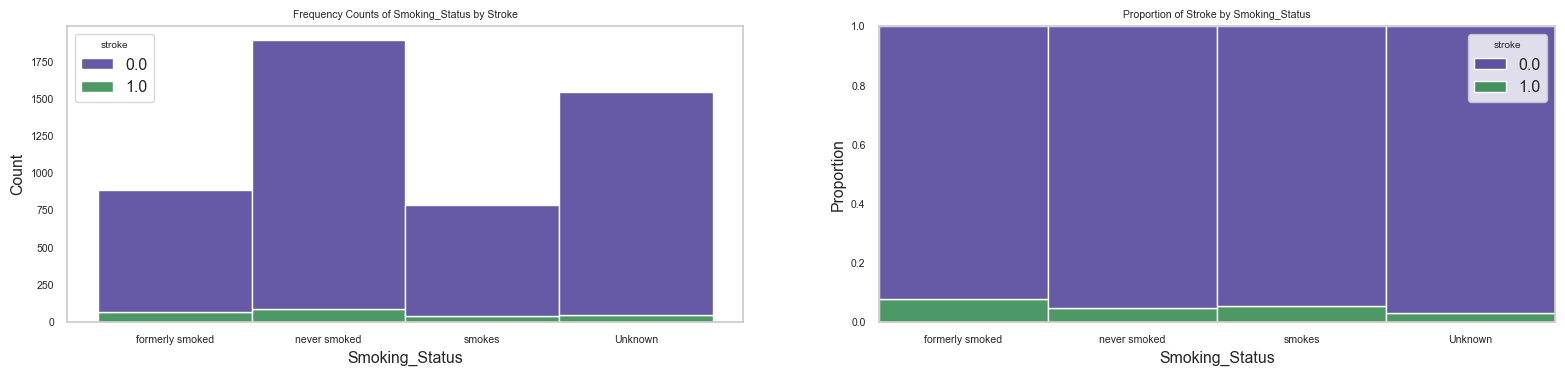

Chi-squared Statistic: 29.1473
P-value: 0.000002


In [28]:
draw_predictor_target_plots(df_imputed, predictor='smoking_status', target='stroke')
chi_squared_test(df_imputed, predictor='smoking_status', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Smoking Status and Stroke</p>
    <ol>
        <ul>Non-smokers are the largest category of patients; Additionally, a big part of patients did not provide their smoking status or were not asked</ul>
        <ul>Proportionally, former smokers seemed to have the biggest proportion of stroke cases. Surprisingly, current smokers and non-smokers shared similar proportions</ul>
        <ul>The p-value provides evidence that smoking status is a statistically significant feature</ul>
    </ol>
</div>

## Feature Correlations
Let's see how the predictors interact between each other and with the target variable.
* Correlation between numeric variables - **Spearman**
* Correlation between categorical variables - **Cramer's V**
* Correlation between all variables - **eta coefficient**

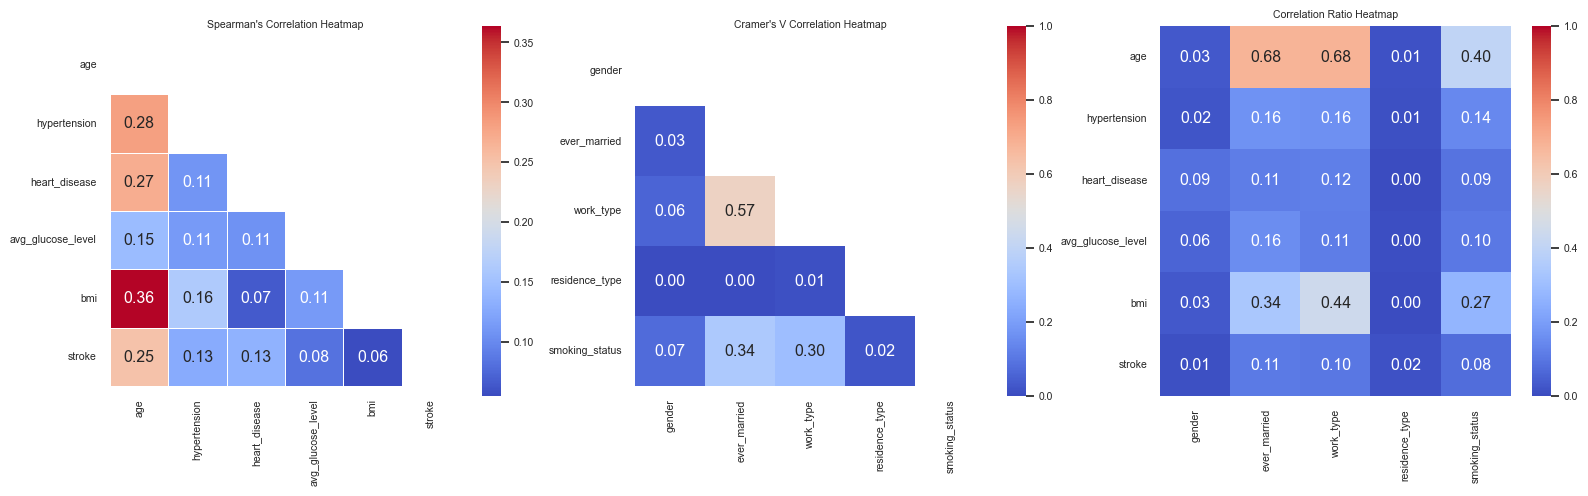

In [29]:
correlation_matrices(df_imputed, numerical_columns, categorical_columns)

<div class="findings">
    <h3>Findings</h3>
    <p>Features' correlation</p>
    <ol>
        <ul>The target variable <b>Stroke</b> does not have any strong or moderate correlations; <b>Stroke - Age</b> is a weak positive correlation</ul>
        <ul><b>BMI</b> and <b>Age</b> have the strongest positive correlation among numerical variables</ul>
        <ul><b>Work Type</b> and <b>Marriage Status</b> have the strongest positive correlation among categorical variables</ul>
        <ul><b>Age</b> has the largest positive correlations with <b>Marriage Status</b> and <b>Work Type</b>, potentially suggesting that marriage status and work type may be consistent for specific age groups</ul>
    </ol>
</div>

## Mutual Information
For the Mutual Information part, we will need to encode the categorical features.

In [30]:
df_imputed_encoded = pd.get_dummies(df_imputed, columns=categorical_columns, drop_first=True)

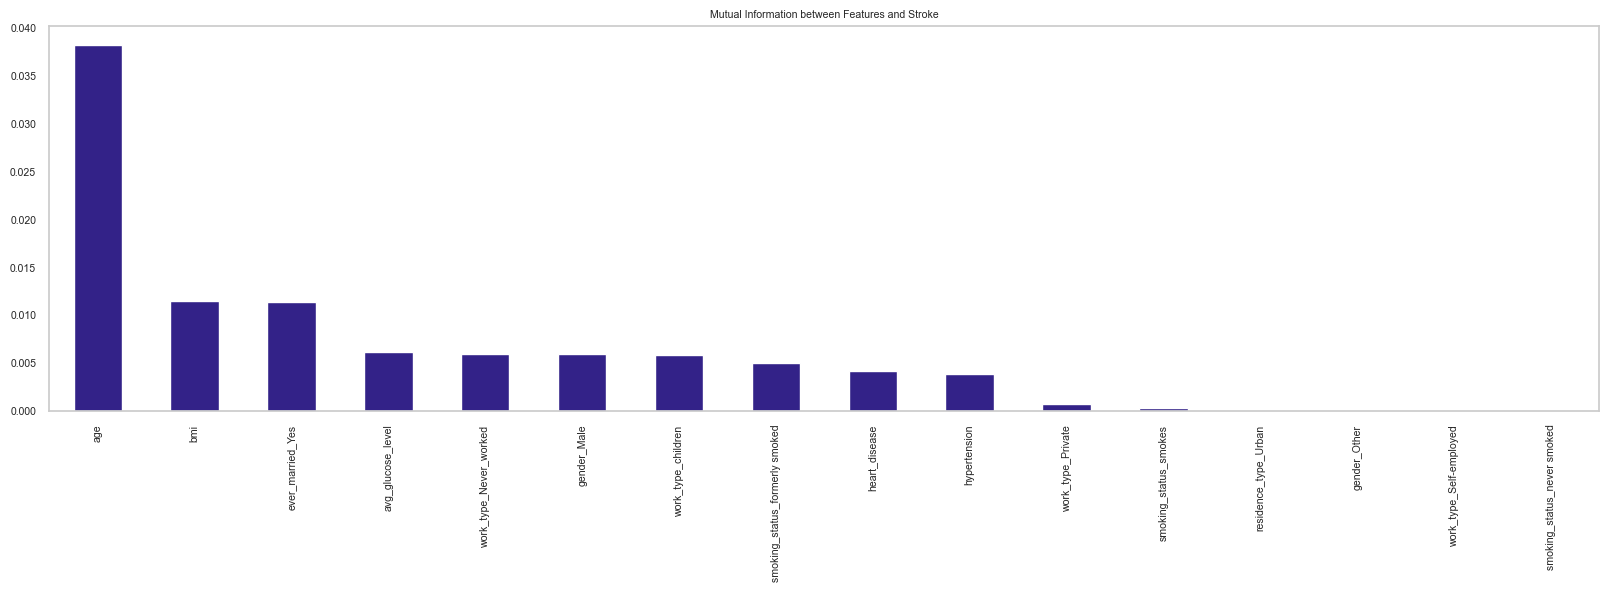

In [31]:
X_mi = df_imputed_encoded.drop(columns=['id', 'stroke'])
y_mi = df_imputed_encoded['stroke']
target_name = 'stroke'

mi = mutual_info_classif(X_mi, y_mi, discrete_features='auto', random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_mi.columns)
plt.figure(figsize=(20, 5))
mi_series.sort_values(ascending=False).plot.bar()
plt.title(f'Mutual Information between Features and {target_name.title()}')
plt.show()

<div class="findings">
    <h3>Findings</h3>
    <p>Mutual Information - Features and Target</p>
    <ol>
        <ul>`age`, `bmi`, `avg_glucose_level` are the most influential numerical variables to eliminate uncertainty in stroke prediction</ul>
        <ul>Marriage status of 'yes' is the most informative feature of the categorical variables</ul>
    </ol>
</div>

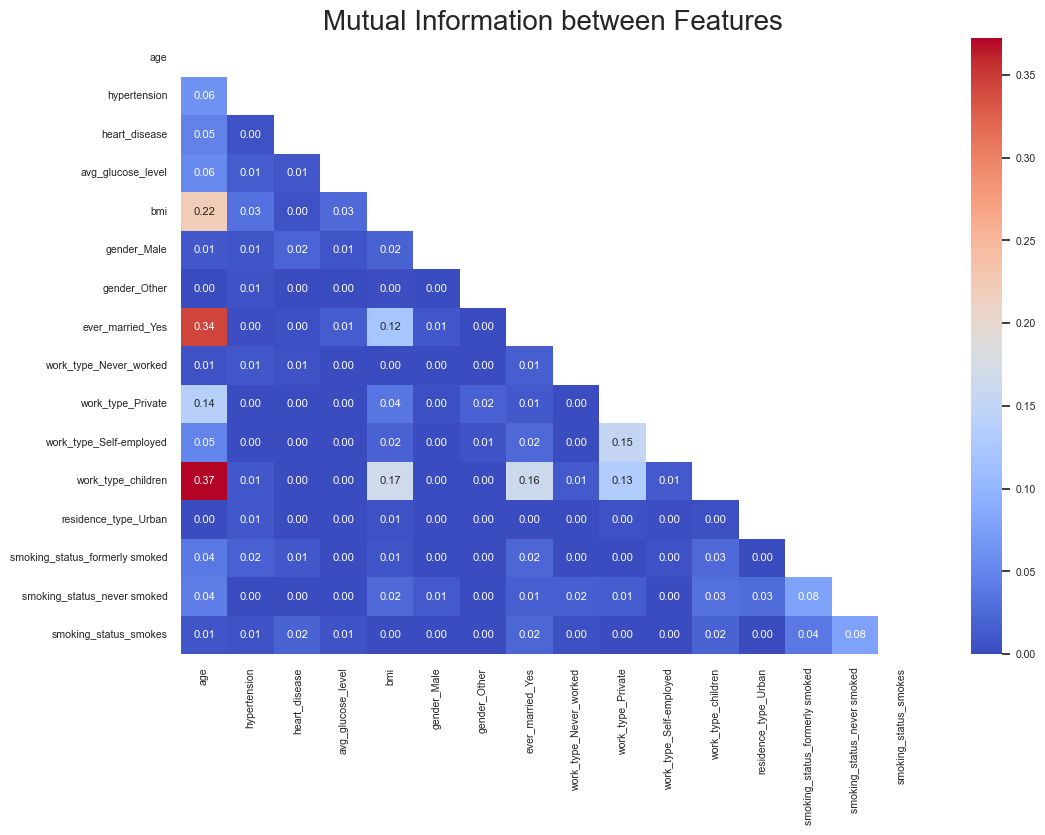

In [32]:
# Calculate mutual information between features
mi_matrix = pd.DataFrame(index=X_mi.columns, columns=X_mi.columns)
for i in X_mi.columns:
    for j in X_mi.columns:
        if i != j:
            mi_matrix.loc[i, j] = mutual_info_regression(X_mi[[i]], X_mi[j]).item()

# Plot mutual information matrix
with sns.plotting_context(font_scale=0.6, rc={"axes.titlesize": 20, "axes.labelsize": 15, "font.size": 8}):
    plt.figure(figsize=(12, 8))
    mask = np.triu(np.ones_like(mi_matrix, dtype=bool))
    sns.heatmap(mi_matrix.astype(float), annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
    plt.title('Mutual Information between Features')
    plt.show()


<div class="findings">
    <h3>Findings</h3>
    <p>Mutual Information</p>
    <ol>
        <ul><b>Age</b> has the highest MI score when it comes to identifying stroke risks</ul>
        <ul>All numeric features had relatively high MI scores</ul>
        <ul><b>Married</b> patients had the highest MI score out of the categorical features</ul>
        <ul><b>Age - Marriage</b> and <b>Age - Work Type (children)</b> have moderate MI scores. We can attribute this to the fact that the database includes children; This population group is less likely to work or be married</ul>
        <ul>As seen previously in the Bivariate Analysis, <b>BMI - Age</b> is reflected as the middle age group having the highest BMI</ul>
    </ol>
</div>

## Outliers

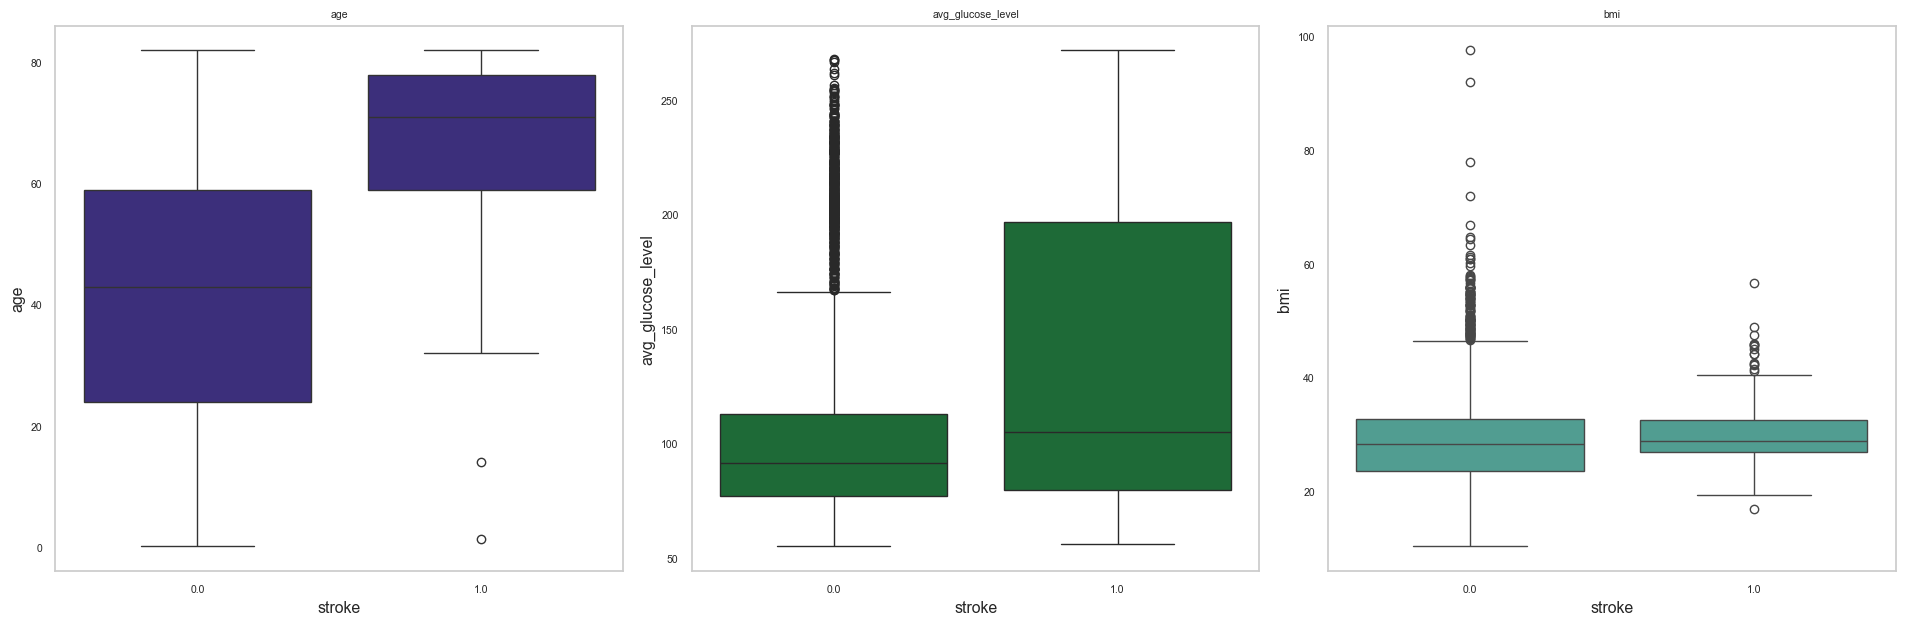

In [33]:
binary_cols = ['hypertension', 'heart_disease', 'stroke']
numerical_columns_excl_binary = [col for col in numerical_columns if col not in binary_cols]
draw_boxplots(df_imputed, target='stroke', predictors=numerical_columns_excl_binary)

<div class="findings">
    <h3>Findings</h3>
    <p>Numerical Variables: Outliers</p>
    <ol>
        <ul>There are two cases of children who had a stroke. The middle 50% of the patients who had a stroke is between ages 60 to 80</ul>
        <ul>There are a lot of cases where patients with high glucose levels did not have a stroke. Generally, higher glucose levels resulted in a stroke</ul>
        <ul>Similarly to blood glucose, there are a lot of patients with very large BMIs who did not have a stroke. Stroke patients generally clustered around 30-35 BMI</ul>
    </ol>
</div>

# Statistical Modeling
* Data Split: **Cross-validation**
* Performance Metric: **Positive class F1 Score**
* Baseline Model: **Random Forest Classifier**
* Tested Models: **Logistic Regression, Random Forest Classifier, XGBoost. Combined using Stacking Classifier.**

## Model Pipeline
For each cross-validation fold, we need to perform the following:
* **Imputation**: KNN imputation for numeric features, most-frequent imputation for categorical.
* **Transformation**: Scaling for numeric features, One-Hot-Encoding for categorical.

The output of the Pipeline will be used as a baseline.

In [34]:
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']

numerical_features = ['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']
categorical_features = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

## Model Baseline

In [35]:
numeric_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', rf)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_pred = cross_val_predict(pipeline, X, y, cv=cv)
y_pred_proba = cross_val_predict(pipeline, X, y, cv=cv,
                                 method='predict_proba')[:, 1]

Baseline Model
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4861
           1       0.20      0.01      0.02       249

    accuracy                           0.95      5110
   macro avg       0.58      0.50      0.50      5110
weighted avg       0.92      0.95      0.93      5110

ROC-AUC Score: 0.778315


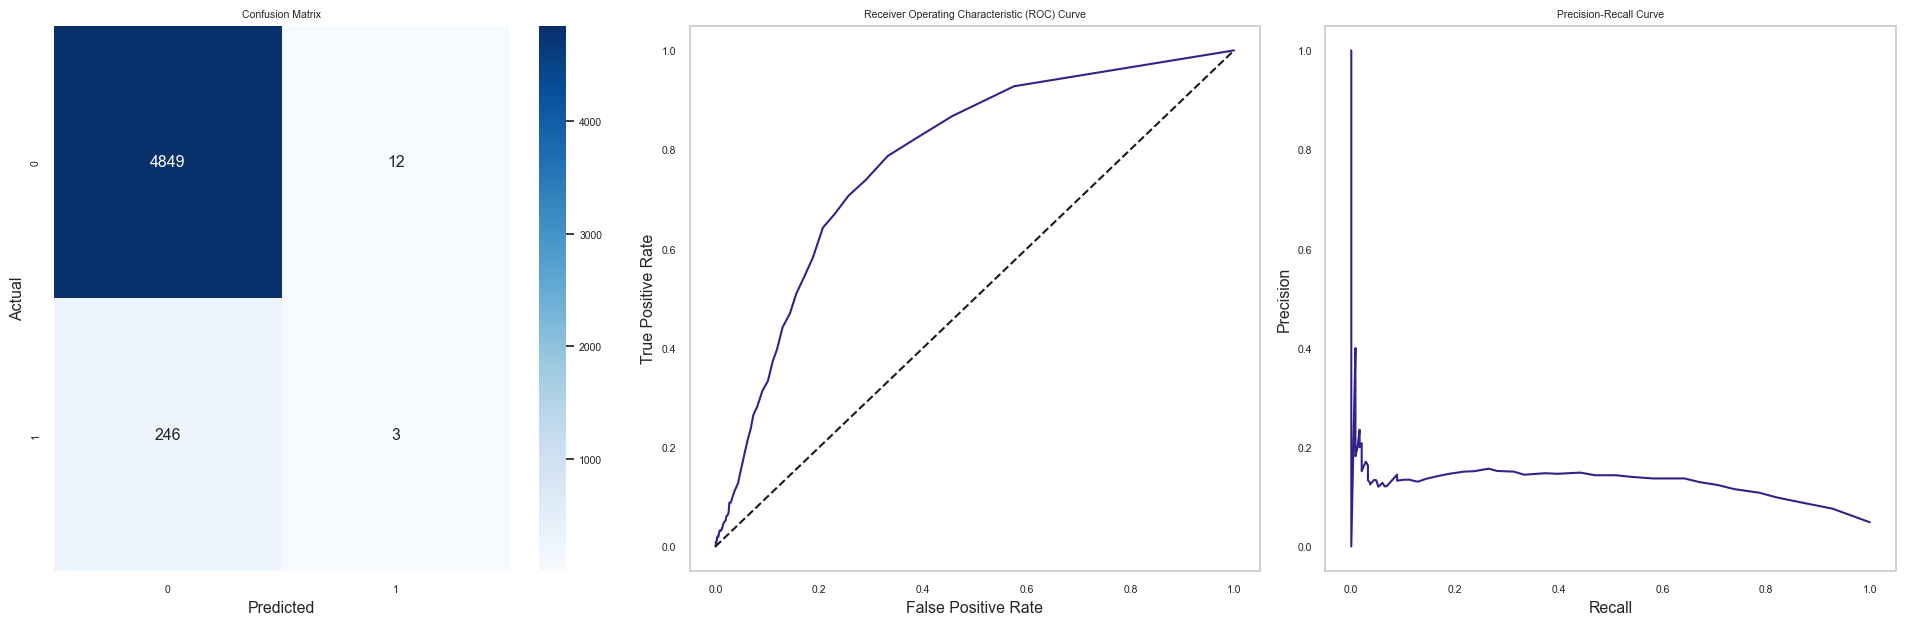

In [36]:
print("Baseline Model")
print(classification_report(y, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y, y_pred_proba), 6))
visualize_performance(y, y_pred, y_pred_proba)

<div class="results">
    <h3>Model Results</h3>
    <p>Baseline Model</p>
    <ol>
        <ul>Almost 95% accuracy, indicating that only 5% of cases were incorrect.</ul>
        <ul>Precision and recall for stroke cases are very poor, at 20% and 1% respectively. The F1 score is <b>0.02</b></ul>
        <ul>The ROC-AUC score may seem great, but it is largely influenced by true negatives and the imbalanced dataset</ul>
        <ul>Precision is quite low across all recall levels, which means when the model predicts a stroke, it is often incorrect</ul>
    </ol>
</div>

We will use the **positive F1 Score** as the performance metric. A delicate balanced between precision and recall is required. Good precision reduces false positives, while recall reduces false negatives. Reducing false positives means that we reduce medical check-ups for potential stroke risk patients. Reducing false negatives means that we correctly identify as many potential stroke risk patients as possible.

In [37]:
baseline_recall = recall_score(y, y_pred)
baseline_precision = precision_score(y, y_pred)
baseline_roc_auc = roc_auc_score(y, y_pred_proba)
baseline_scores = [baseline_recall, baseline_precision, baseline_roc_auc]

Let's initialize our models and parameter grid variables, which we will update throughout the process.

In [38]:
models = {
    'Baseline': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
}
param_grids = {
    'Baseline': {},
    'Logistic Regression': {},
    'Random Forest': {},
    'XGBoost': {},
}
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ])

## Class Weights
The first step is to address the dataset imbalance problem; Only 5% of the instances have patients who experienced a stroke. Other feature engineering opportunities will not show any noticeable benefits until we set this part first.

In [39]:
scale_pos_weight = (len(y) - sum(y)) / sum(y)

for name, model in models.items():
    if name == 'Logistic Regression' or name == 'Random Forest':
        model.set_params(class_weight='balanced')
    elif name == 'XGBoost':
        model.set_params(scale_pos_weight=scale_pos_weight)

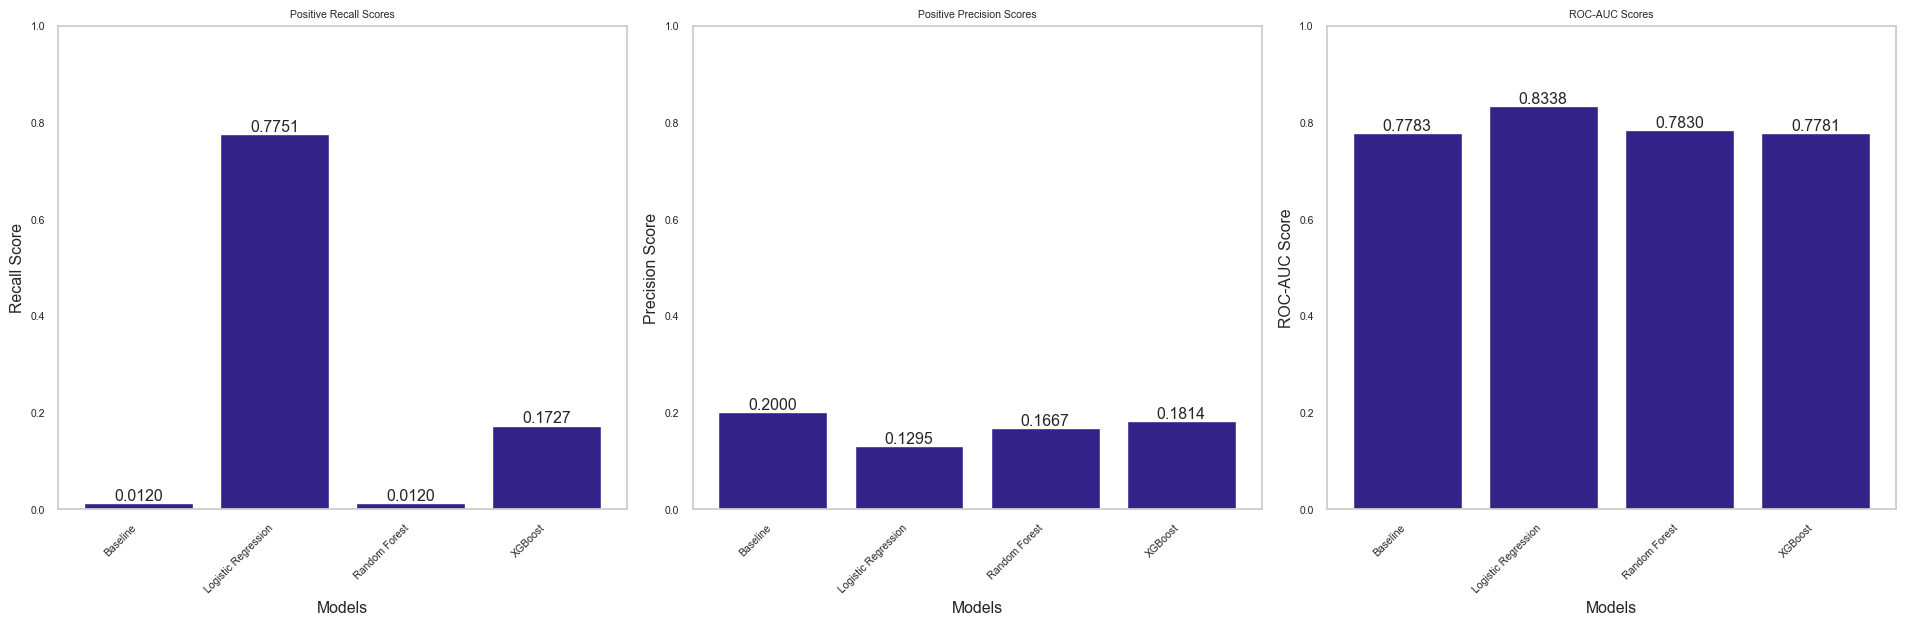

In [40]:
benchmark_models(pipeline, param_grids, models, X, y, cv, baseline_scores)

<div class="results">
    <h3>Model Results</h3>
    <p>Class Weights</p>
    <ol>
        <ul>With class weights implementation, the Logistic Regression has very good positive recall performance. Unfortunately, the precision score is the worst, which indicates that the model has a lot of false positives (predicting non-stroke patients as potentially at a risk of stroke)</ul>
        <ul>XGBoost has the most similar positive precision and recall so far</ul> 
    </ol>
</div>

## Feature Transformations
The next step is performing numerical features transformations to get better performance and reduce overfitting.
* Log transformations for skewed features
* Binning of numerical variables into categorical features

<div class="Note">
    <h3>Note</h3>
    <p>Feature Engineering on a copy Dataset</p>
    <ul>
        <li>We will perform KNN imputation, log transformation and feature additions on the dataset, and will pass the modified dataset through further ML pipelines. Trying to incorporate these steps in a pipeline is unecessary complexity and waste of time.</li>
    </ul>
</div>

In [41]:
X_model = X.copy()
y_model = y.copy()

# Impute missing BMI values
imputer = KNNImputer(n_neighbors=3)
X_model['bmi'] = imputer.fit_transform(X_model[['bmi']])

First, let's explore whether any of our numeric features (excl. binary) need log transformations. As a general rule, if the skewness of the numerical distribution exceeds the absolute value of 0.5, we may benefit from a log transformation.

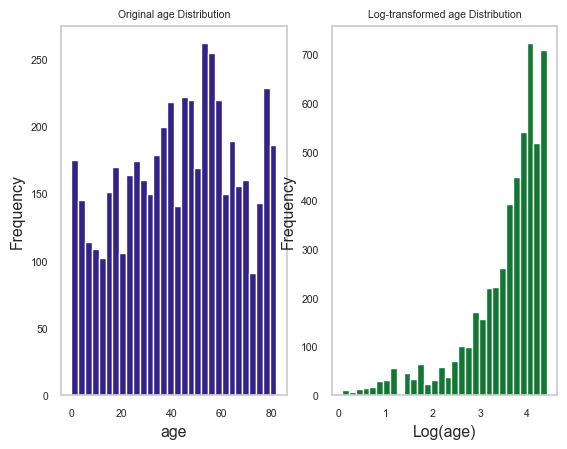

age skewness: -0.14
No transformation needed


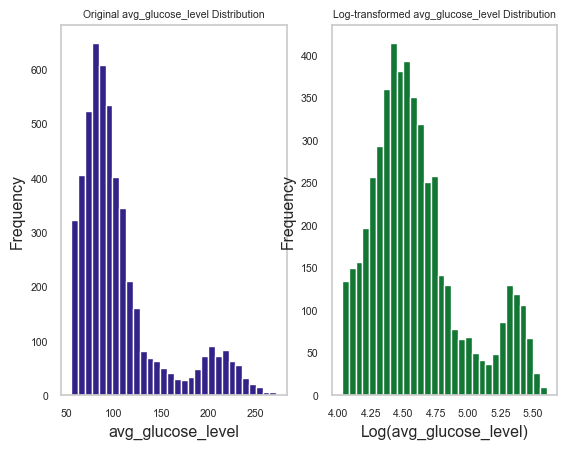

avg_glucose_level skewness: 1.57
Log transformation applied. Column avg_glucose_level_log
Log-transformed avg_glucose_level skewness: 0.89


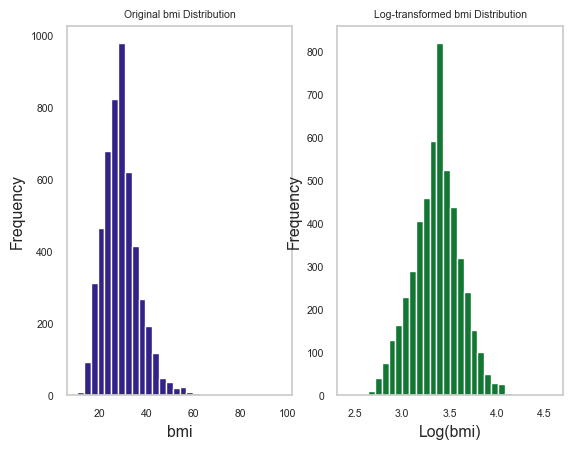

bmi skewness: 1.08
Log transformation applied. Column bmi_log
Log-transformed bmi skewness: 0.02


In [42]:
for feature in numerical_columns_excl_binary:
    draw_original_log_distribution(X_model, feature)
    print(f"{feature} skewness: {X_model[feature].skew():.2f}")

    if abs(X_model[feature].skew()) > 0.5:
        X_model[f'{feature}_log'] = np.log1p(X_model[feature])
        print(f"Log transformation applied. Column {feature}_log")
        print(f"Log-transformed {feature} skewness: {X_model[f'{feature}_log'].skew():.2f}")
    else:
        print("No transformation needed")

Log transformation reduced the skewness for `avg_glucose_level` and `bmi` significantly.

Next, using our correlation and feature importance findings, let's create some new features:
* `bmi_category` - categorize BMI into groups
* `age_group` - categorize age into groups
* `glucose_category` - categorize glucose level into groups
* `lifestyle_score` - numerical representation of healthiness taking into consideration smoking, bmi and glucose level
* `work_stress_proxy` - numerical representation of employment, hypertension, glucose and BMI
* `smoking_risk` - ordinal representation of smoking status, where past or present smokers have a higher score
* `age_bmi_interaction` - product of age and BMI
* `glucose_bmi_interaction` - product of glucose level and BMI

In [43]:
X_model = add_new_features(X_model)

In [44]:
# Update the list of numerical and categorical features
numerical_features = X_model.select_dtypes(exclude='object').columns
categorical_features = X_model.select_dtypes(include='object').columns

Before we benchmark, let's look at feature correlations and remove redundant features.

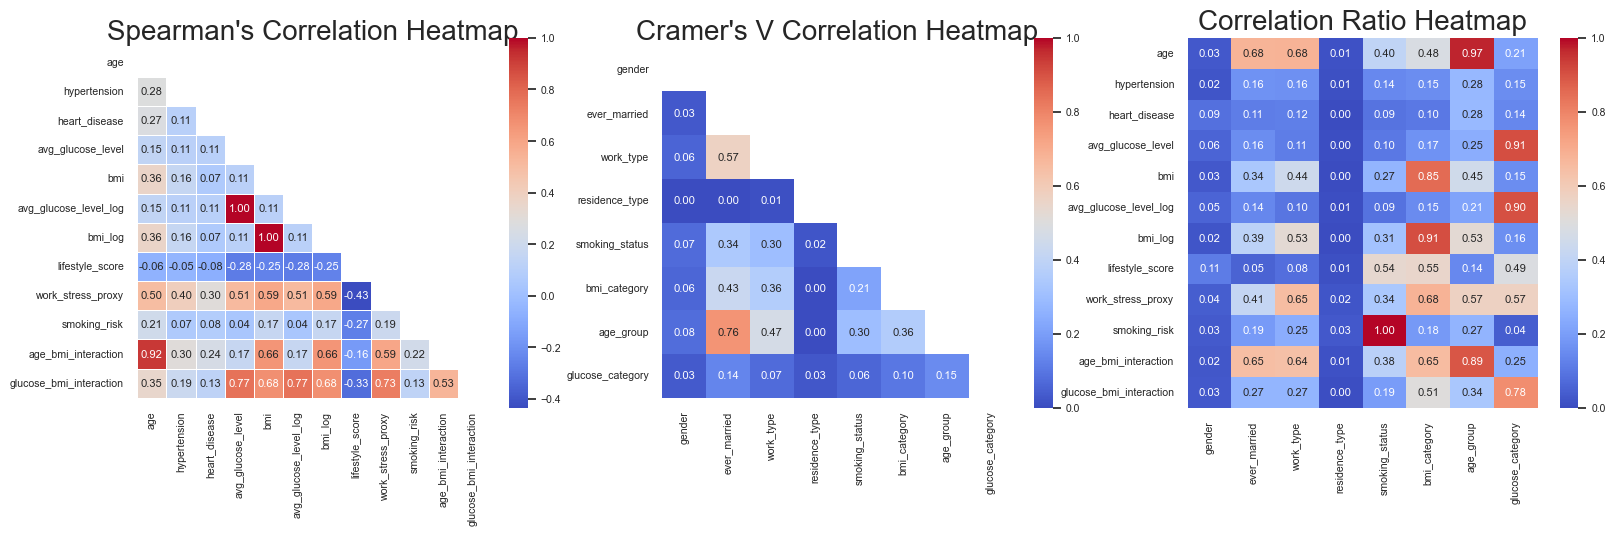

In [45]:
with sns.plotting_context(font_scale=0.6, rc={"axes.titlesize": 20, "axes.labelsize": 15, "font.size": 8}):
    correlation_matrices(X_model, numerical_features, categorical_features)

There are some redundant columns that we will remove.
* `bmi` - the `_log` variant has less skewness
* `avg_glucose_level` - the `_log` variant has less skewness
* `smoking_status` - we have a `smoking_risk` ordinal feature which provides more information

In [46]:
X_model = remove_columns(X_model, ['bmi', 'avg_glucose_level', 'smoking_status'])

# Update the pipeline
numerical_features = X_model.select_dtypes(exclude='object').columns
categorical_features = X_model.select_dtypes(include='object').columns
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

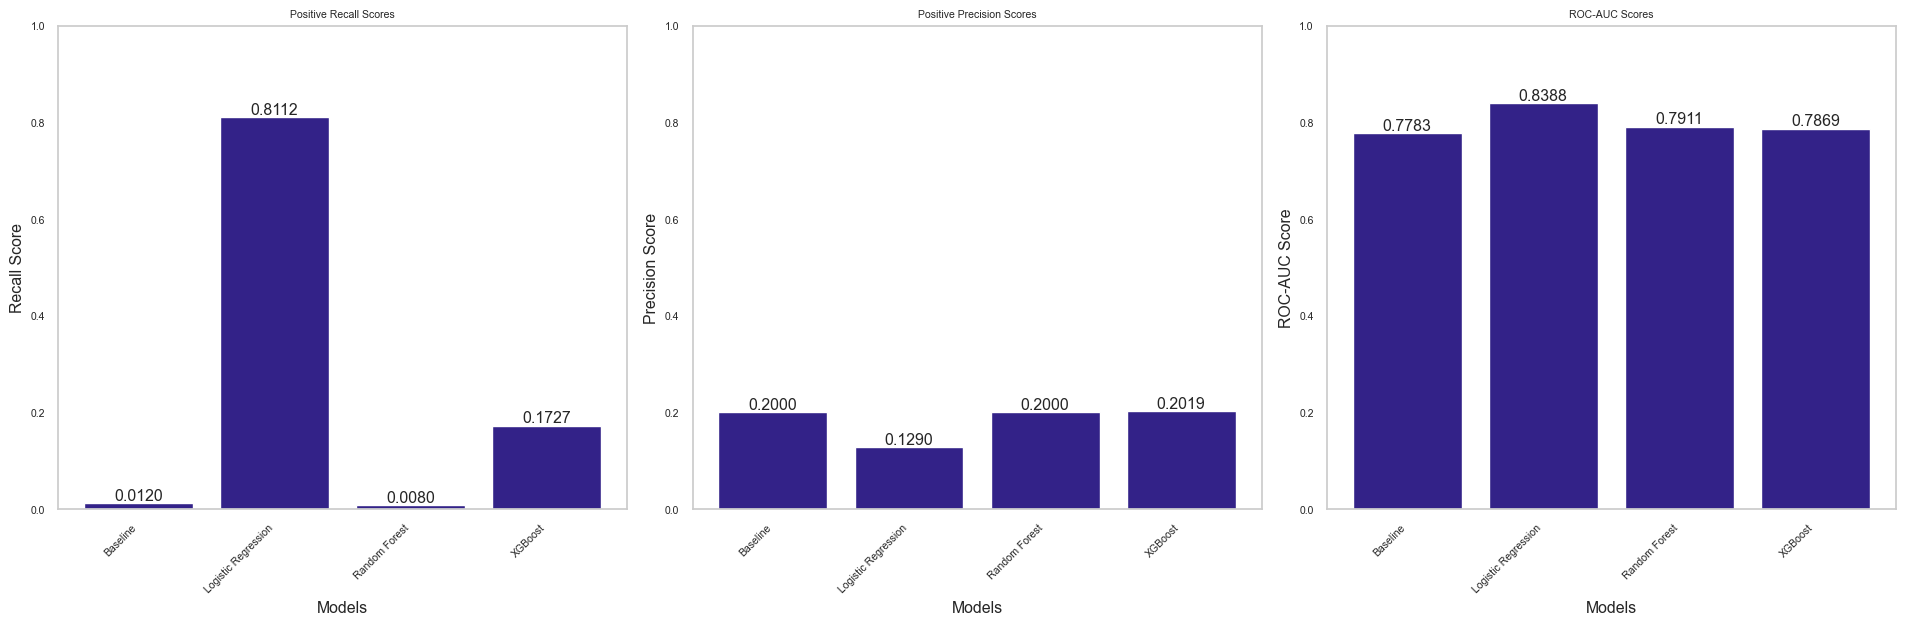

In [47]:
benchmark_models(pipeline, param_grids, models, X_model, y_model, cv, baseline_scores)

<div class="results">
    <h3>Model Results</h3>
    <p>Feature Transformation & addition</p>
    <ul>
        <ul>Logistic Regression - adding new features and removing multicollinear features improved all metrics</ul>
        <ul>Random Forest - performs worse than baseline in positive recall, will need further adjustments</ul>
        <ul>XGBoost - slight performance improvement in positive precision</ul>
    </ul>
</div>

We have a solid base to tune each of our models individually. After we've exhausted their options, we will create a meta-model through the stacking classifier.

## Logistic Regression Model
First, let's work on optimizing the Logistic regression model.

In [48]:
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline_lr = ImbPipeline([
    ('preprocessor', preprocessor_lr),
    ('resampler', RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_STATE)),
    ('feature_selection', SelectFromModel(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))),
    ('model', LogisticRegression(random_state=RANDOM_STATE)),
])

param_grid_lr = {
    'model__C': [0.1, 0.5, 1, 5, 10],
    'model__penalty': ['l2', 'elasticnet'],
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'model__max_iter': [1000, 5000, 10000],
    'model__l1_ratio': [0, 0.1, 0.5, 0.7, 1],
    'model__warm_start': [True, False],
    'model__intercept_scaling': [1, 2, 3, 4, 5],
    'model__fit_intercept': [True, False],
    'feature_selection__threshold': ['mean', 'median', '2.*mean'],
    'feature_selection__estimator__penalty': ['l1', 'l2'],
    'feature_selection__estimator__C': [0.1, 0.5, 1.0, 5, 10],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'resampler': [RandomOverSampler(random_state=RANDOM_STATE), SMOTE(random_state=RANDOM_STATE)],
    'resampler__sampling_strategy': ['minority', 'not majority', 'all']
}

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      4861
           1       0.13      0.78      0.22       249

    accuracy                           0.74      5110
   macro avg       0.56      0.76      0.53      5110
weighted avg       0.94      0.74      0.81      5110

ROC-AUC Score: 0.834123


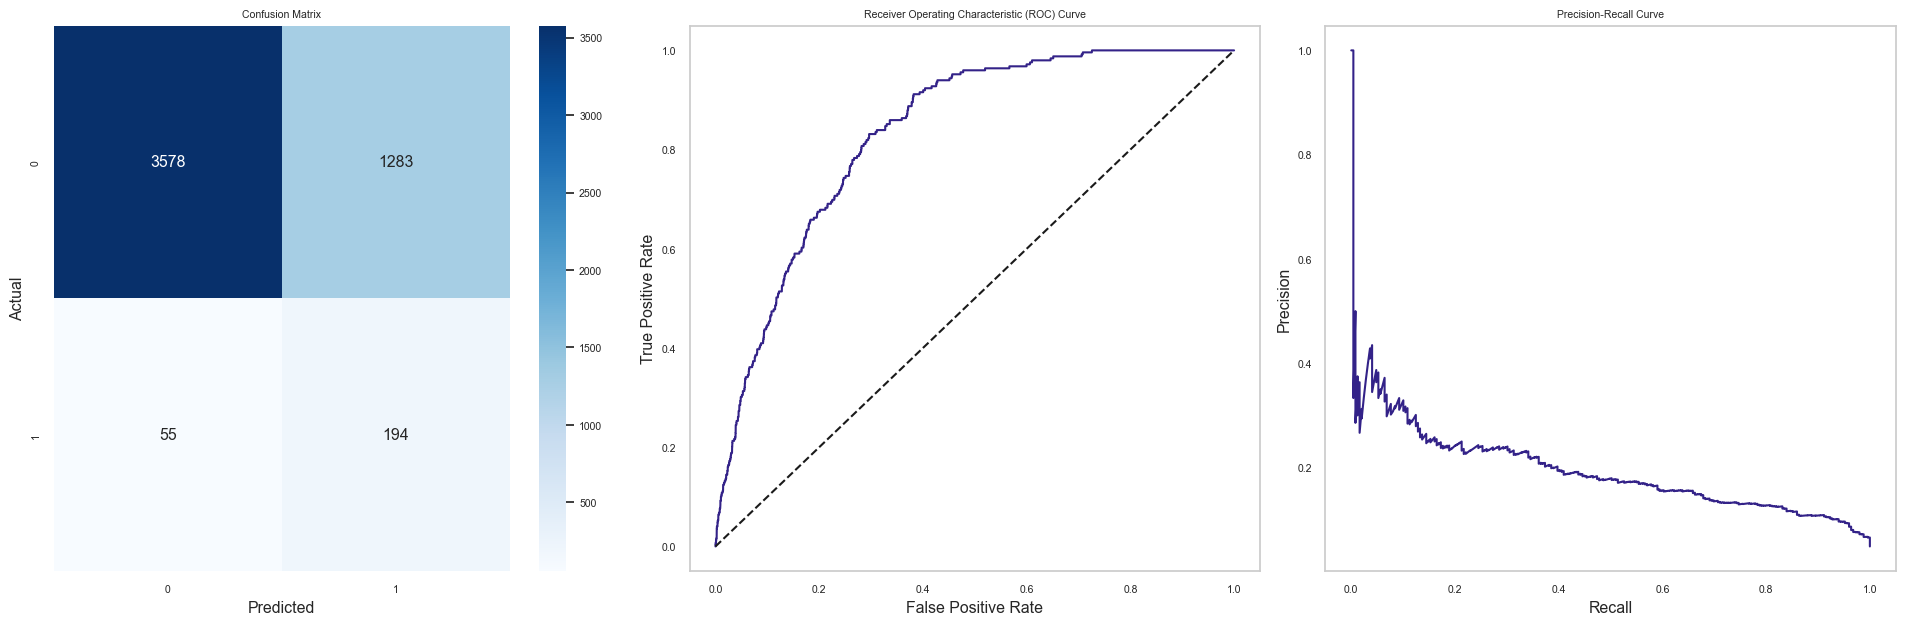

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, average='micro', pos_label=1)

grid_search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=cv,
    scoring=scorer,
    n_jobs=2,
    random_state=RANDOM_STATE,
)

grid_search_lr.fit(X_model, y_model)
best_model = grid_search_lr.best_estimator_
y_pred = cross_val_predict(best_model, X_model, y_model, cv=cv)
y_pred_proba = cross_val_predict(best_model, X_model, y_model, cv=cv, method='predict_proba')[:, 1]
resampler_lr = best_model.named_steps['resampler']

print(classification_report(y_model, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_model, y_pred_proba), 6))
visualize_performance(y_model, y_pred, y_pred_proba)

<div class="results">
    <h3>Model Results</h3>
    <p>Tuned Logistic Regression model</p>
    <ul>
        <ul>Solid positive class recall score, identifying 80% of stroke victims correctly</ul>
        <ul>As a trade-off, the precision is much lower, with a lot of false positives</ul>
        <ul>Solid ROC-AUC score with a positive F1 score of 0.22, which is 0.20 points higher than baseline</ul>
    </ul>
</div>

## Random Forest Model
Second, let's improve the random forest model:
* `BalancedRandomForestClassifier()` model for better performance with the imbalanced dataset
* Resampling through SMOTE
* Hyperparameter tuning for the model and feature selection

In [50]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor_rf),
    ('resampler', SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)),
    ('feature_selection', SelectFromModel(BalancedRandomForestClassifier(random_state=RANDOM_STATE,
                                                                         replacement=True, bootstrap=True))),
    ('model', BalancedRandomForestClassifier(random_state=RANDOM_STATE, replacement=True, bootstrap=True)),
])

param_grid_rf = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': [2, 5, 10, 15, 20],
    'model__min_samples_leaf': [1, 2, 4, 6, 8],
    'model__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'model__replacement': [True, False],
    'model__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'feature_selection__estimator__n_estimators': [50, 100, 150, 200],
    'feature_selection__estimator__criterion': ['gini', 'entropy'],
    'feature_selection__estimator__bootstrap': [True, False],
    'feature_selection__estimator__warm_start': [True, False],
    'resampler': [RandomOverSampler(random_state=RANDOM_STATE), SMOTE(random_state=RANDOM_STATE)],
    'resampler__sampling_strategy': ['minority', 'not majority', 'all']
}

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      4861
           1       0.17      0.53      0.26       249

    accuracy                           0.85      5110
   macro avg       0.57      0.70      0.59      5110
weighted avg       0.93      0.85      0.89      5110

ROC-AUC Score: 0.823911


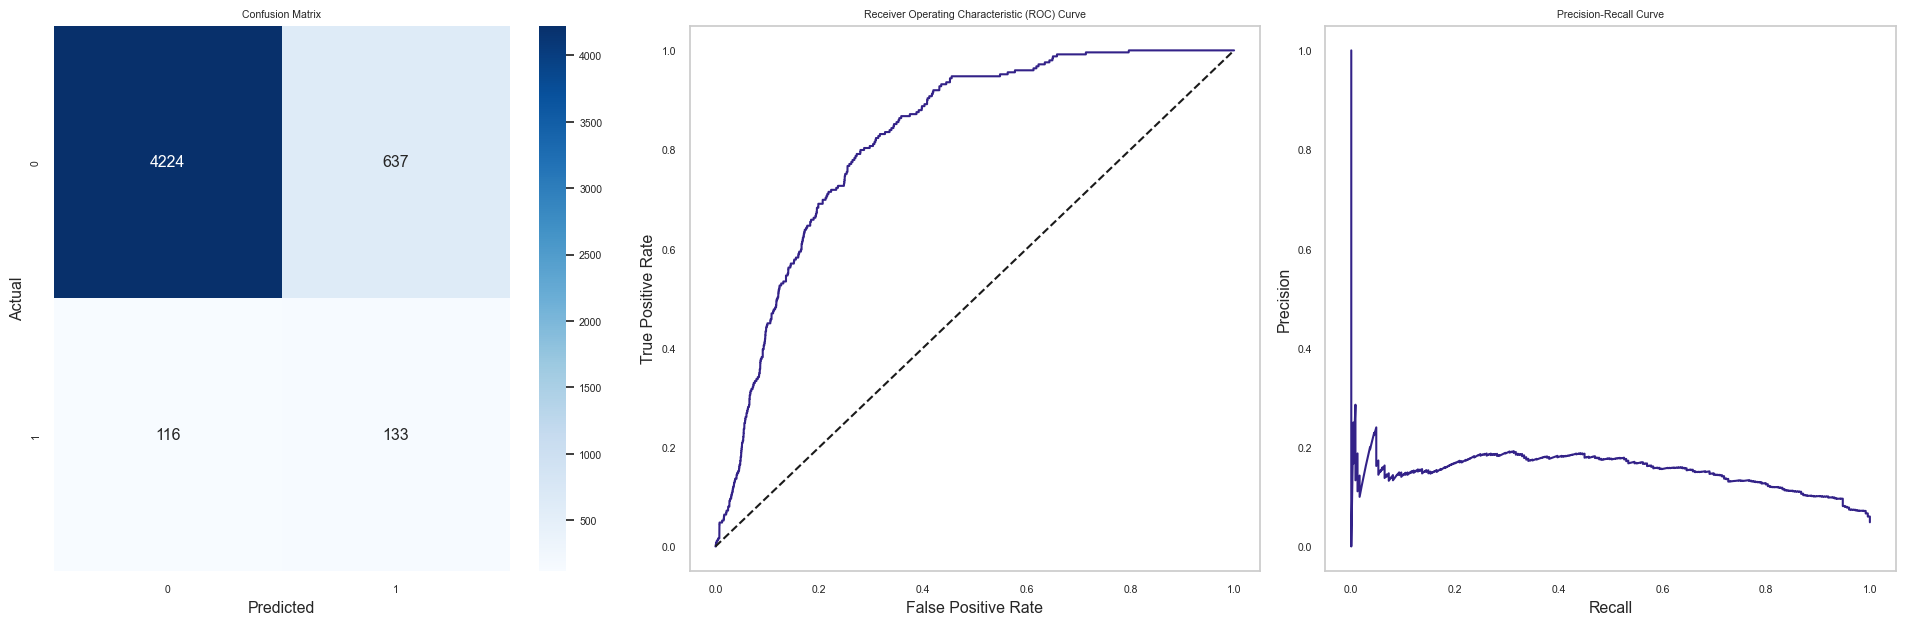

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, pos_label=1)

grid_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=cv,
    scoring=scorer,
    n_jobs=2,
    random_state=RANDOM_STATE
)

grid_search_rf.fit(X_model, y)
best_model = grid_search_rf.best_estimator_
y_pred = cross_val_predict(best_model, X_model, y_model, cv=cv)
y_pred_proba = cross_val_predict(best_model, X_model, y_model, cv=cv, method='predict_proba')[:, 1]
resampler_rf = best_model.named_steps['resampler']

print(classification_report(y_model, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_model, y_pred_proba), 6))
visualize_performance(y_model, y_pred, y_pred_proba)

<div class="results">
    <h3>Model Results</h3>
    <p>Tuned Random Forest Classifier model</p>
    <ul>
        <ul>Moderate positive class recall score, identifying more than half of stroke victims correctly</ul>
        <ul>Much better positive class precision score, with less false positives</ul>
        <ul>Great ROC-AUC score with a positive F1 score of 0.26, which is 0.24 points higher than baseline</ul>
    </ul>
</div>

## XGB Classifier
Finally, let's tune the XGBoost model:
* Minority class sampling using `RandomOverSampler()`
* Model, numeric values scaling and feature selection hyperparameters tuning

In [52]:
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor_xgb),
    ('resampler', RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_STATE)),
    ('feature_selection', SelectFromModel(XGBClassifier(random_state=RANDOM_STATE))),
    ('model', XGBClassifier(random_state=RANDOM_STATE)),
])

param_grid_xgb = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__n_estimators': [100, 200, 500, 1000],
    'model__max_depth': [3, 5, 7, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.5, 0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'model__scale_pos_weight': [1, 5, 10, 50, 100],
    'model__gamma': [0, 0.1, 0.2, 0.5],
    'model__reg_alpha': [0, 0.1, 1, 10],
    'model__reg_lambda': [0, 0.1, 1, 10],
    'model__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'preprocessor__num__scaler': [RobustScaler(), StandardScaler(), MinMaxScaler()],
    'feature_selection__estimator__n_estimators': [50, 100, 150, 200],
    'feature_selection__estimator__criterion': ['gini', 'entropy'],
    'feature_selection__estimator__bootstrap': [True, False],
    'feature_selection__estimator__warm_start': [True, False],
}

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      4861
           1       0.18      0.55      0.27       249

    accuracy                           0.86      5110
   macro avg       0.58      0.71      0.60      5110
weighted avg       0.94      0.86      0.89      5110

ROC-AUC Score: 0.830939


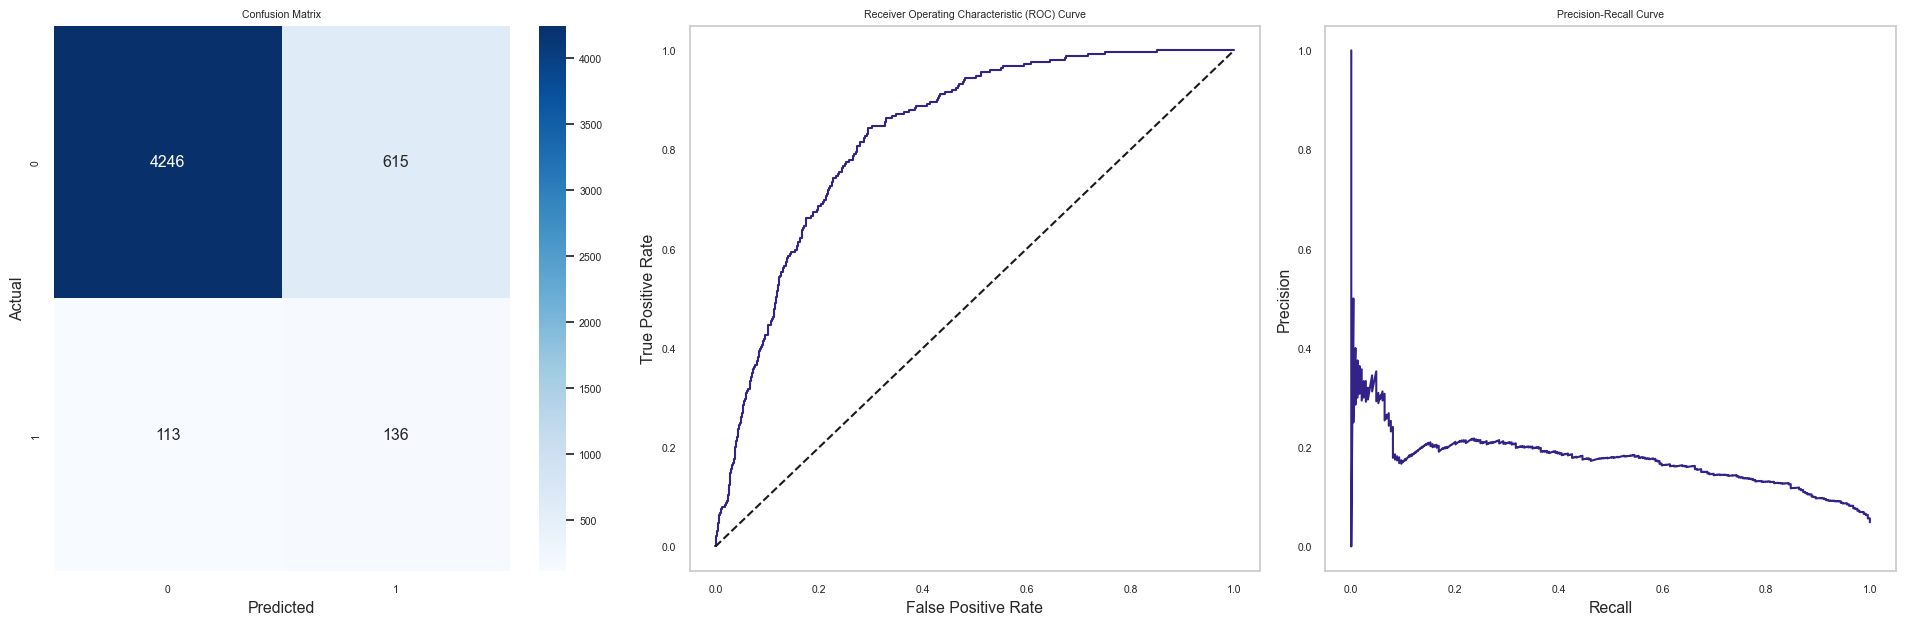

In [53]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, pos_label=1)

grid_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=cv,
    scoring=scorer,
    n_jobs=2,
    random_state=RANDOM_STATE
)

grid_search_xgb.fit(X_model, y_model)
best_model = grid_search_xgb.best_estimator_
y_pred = cross_val_predict(best_model, X_model, y_model, cv=cv)
y_pred_proba = cross_val_predict(best_model, X_model, y_model, cv=cv, method='predict_proba')[:, 1]
resampler_xgb = best_model.named_steps['resampler']

print(classification_report(y_model, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_model, y_pred_proba), 6))
visualize_performance(y_model, y_pred, y_pred_proba)

<div class="results">
    <h3>Model Results</h3>
    <p>Tuned XGBoost model</p>
    <ul>
        <ul>Moderate positive class recall score, identifying more than half of stroke victims correctly</ul>
        <ul>Much better positive class precision score, with less false positives</ul>
        <ul>Great ROC-AUC score with a positive F1 score of 0.27, which is 0.25 points higher than baseline</ul>
    </ul>
</div>

## Model Ensembling
We created three decent models with the following characteristics:
* **Logistic Regression** - minimized false negatives
* **Random Forest & XGB Classifiers** - minimized false positives with moderate impact to false negatives

We will now try to combine these three models into one meta-model using the stacking classifier.

In [54]:
best_params_lr = grid_search_lr.best_params_
best_params_rf = grid_search_rf.best_params_
best_params_xgb = grid_search_xgb.best_params_

best_lr_model = ImbPipeline([
    ('preprocessor', preprocessor_lr),
    ('resampler', resampler_lr),
    ('feature_selection', SelectFromModel(LogisticRegression(solver='liblinear',
                                                             random_state=RANDOM_STATE))),
    ('model', LogisticRegression(random_state=RANDOM_STATE,
                                 **{k.split('__')[-1]: v for k, v in best_params_lr.items() if k.startswith('model__')}))
])

best_rf_model = ImbPipeline([
    ('preprocessor', preprocessor_rf),
    ('resampler', resampler_rf),
    ('feature_selection', SelectFromModel(BalancedRandomForestClassifier(random_state=RANDOM_STATE,
                                                                         replacement=True, bootstrap=True))),
    ('model', BalancedRandomForestClassifier(random_state=RANDOM_STATE,
                                             **{k.split('__')[-1]: v for k, v in best_params_rf.items() if k.startswith('model__')}))
])

best_xgb_model = ImbPipeline([
    ('preprocessor', preprocessor_xgb),
    ('resampler', resampler_xgb),
    ('feature_selection', SelectFromModel(XGBClassifier(random_state=RANDOM_STATE))),
    ('model', XGBClassifier(random_state=RANDOM_STATE,
                            **{k.split('__')[-1]: v for k, v in best_params_xgb.items() if k.startswith('model__')}))
])

stacking_classifier = StackingClassifier(
    estimators = [
        ('lr', best_lr_model),
        ('rf', best_rf_model),
        ('xgb', best_xgb_model)
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5,
    stack_method='predict_proba'
)

param_grid_stacking = {
    'final_estimator__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'final_estimator__C': [0.1, 0.5, 1, 5, 10],
    'xgb__model__learning_rate': [0.01, 0.1],
    'rf__model__n_estimators': [150, 250],
    'lr__model__C': [0.5, 5],
}

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      4861
           1       0.17      0.65      0.27       249

    accuracy                           0.83      5110
   macro avg       0.57      0.74      0.59      5110
weighted avg       0.94      0.83      0.87      5110

ROC-AUC Score: 0.840788


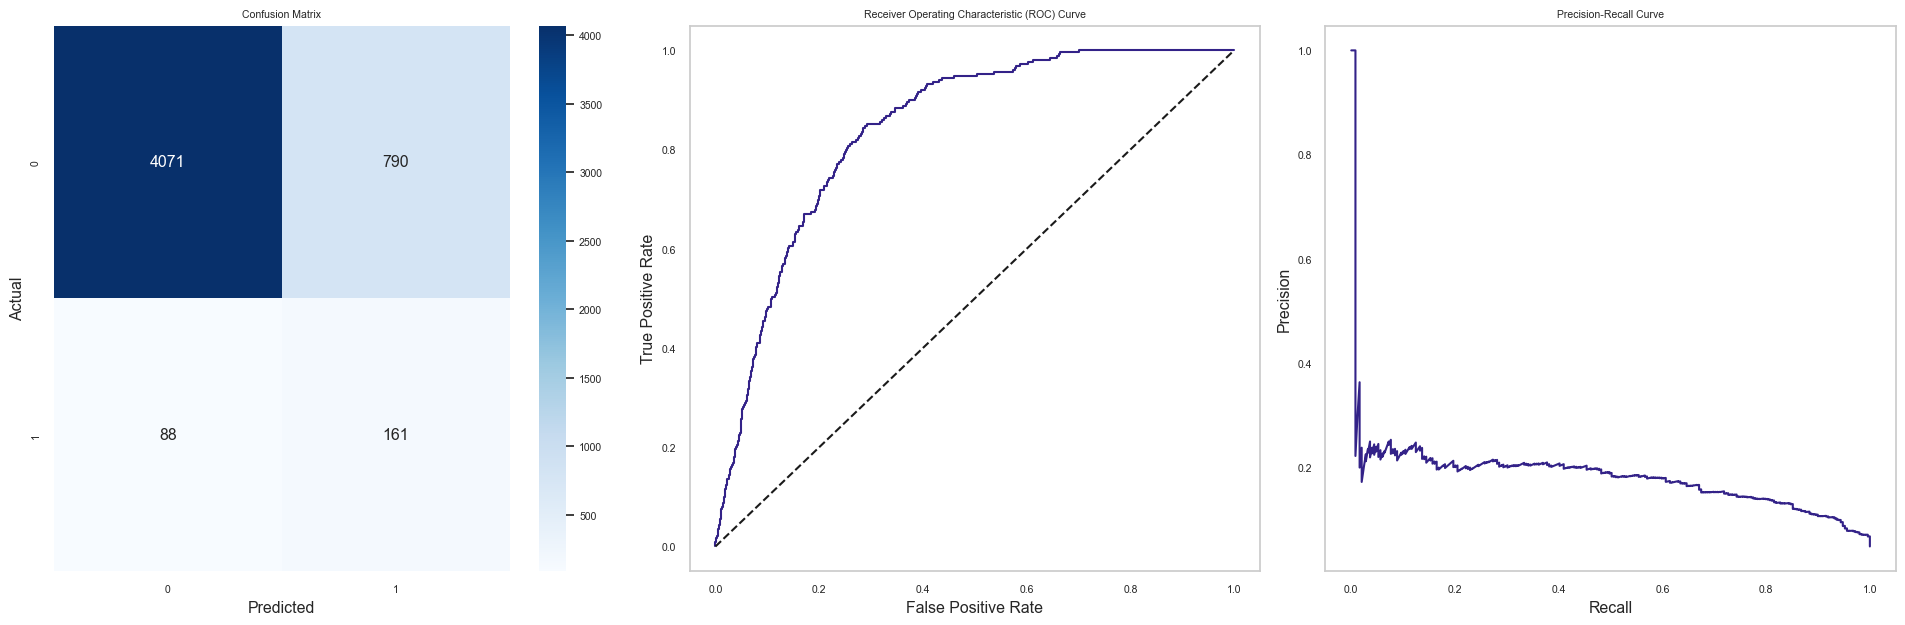

In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, pos_label=1)

grid_search_stacking = RandomizedSearchCV(
    stacking_classifier,
    param_grid_stacking,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_search_stacking.fit(X_model, y_model)
best_model = grid_search_stacking.best_estimator_
y_pred_stacking = cross_val_predict(best_model, X_model, y_model, cv=cv)
y_pred_proba_stacking = cross_val_predict(best_model, X_model, y_model, cv=cv, method='predict_proba')[:, 1]

print(classification_report(y_model, y_pred_stacking))
print("ROC-AUC Score:", round(roc_auc_score(y_model, y_pred_proba_stacking), 6))
visualize_performance(y_model, y_pred_stacking, y_pred_proba_stacking)

<div class="results">
    <h3>Model Results</h3>
    <p>Stacking Classifier meta-model</p>
    <ul>
        <ul>Improved positive class recall score, identifying almost two-thirds of stroke victims correctly</ul>
        <ul>Very decent precision score, maintaining a moderate false positives count while keeping recall</ul>
        <ul>Great ROC-AUC score with a positive F1 score of 0.27, which is 0.25 points higher than baseline</ul>
    </ul>
</div>

Let's export the model and deploy it using Streamlit. The Streamlit app link will be provided in the `README`.

In [56]:
joblib.dump(best_model, 'stroke_prediction_model.joblib')

['stroke_prediction_model.joblib']

# Summary
## Findings
The Stacking Classifier meta-model with Logistic Regression as the final estimator has produced a decent model, which identified approximately two-thirds of stroke patients correctly. Additionally, it maintained a moderate false positive count.

From a cost perspective, the most likely use case for the model is suggesting medical check-ups for patients that have a stroke prediction above a certain threshold (for instance, 30%). Individual calls with each risk group patient would be too costly, since the model still has a fairly large false positive count, where roughly 80% of the patients from the dataset did not have a stroke, yet were identified as a patient that suffered from a stroke.

## Feature Importances
Since the context of the study is medical application, it is important to specify which features contributed the most to stroke risk; The information will support medical specialist-patient conversations. For this, we will use Permutation Importance.

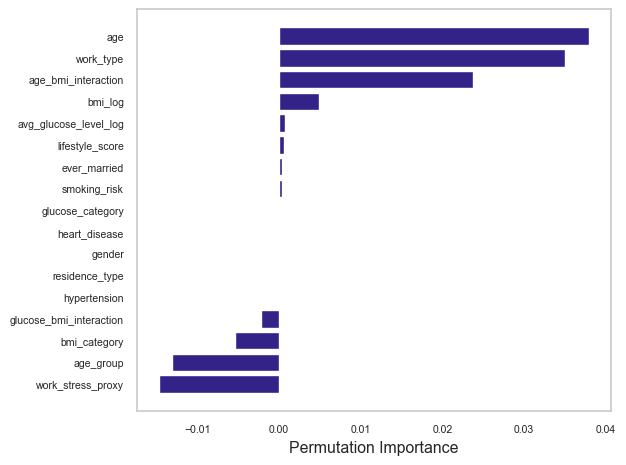

In [57]:
result = permutation_importance(best_model, X_model, y_model, n_repeats=10, random_state=42)
 
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X_model.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_model.shape[1]), X_model.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

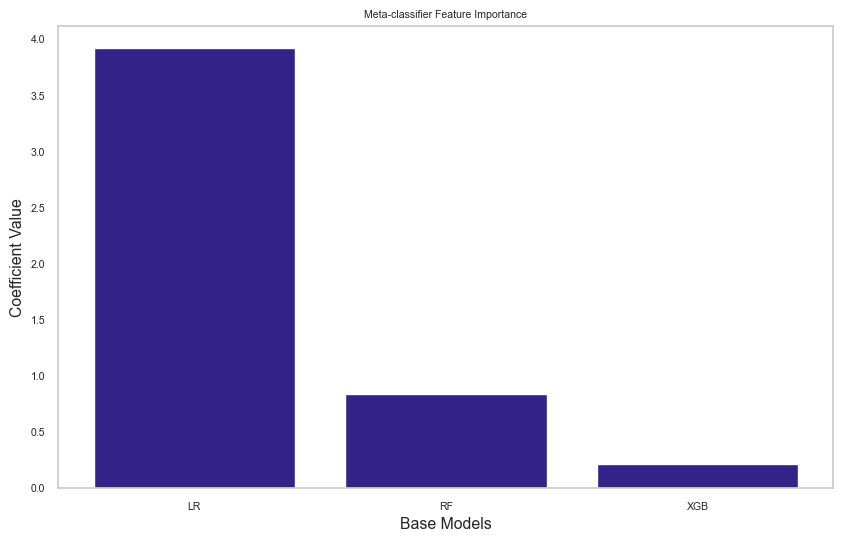

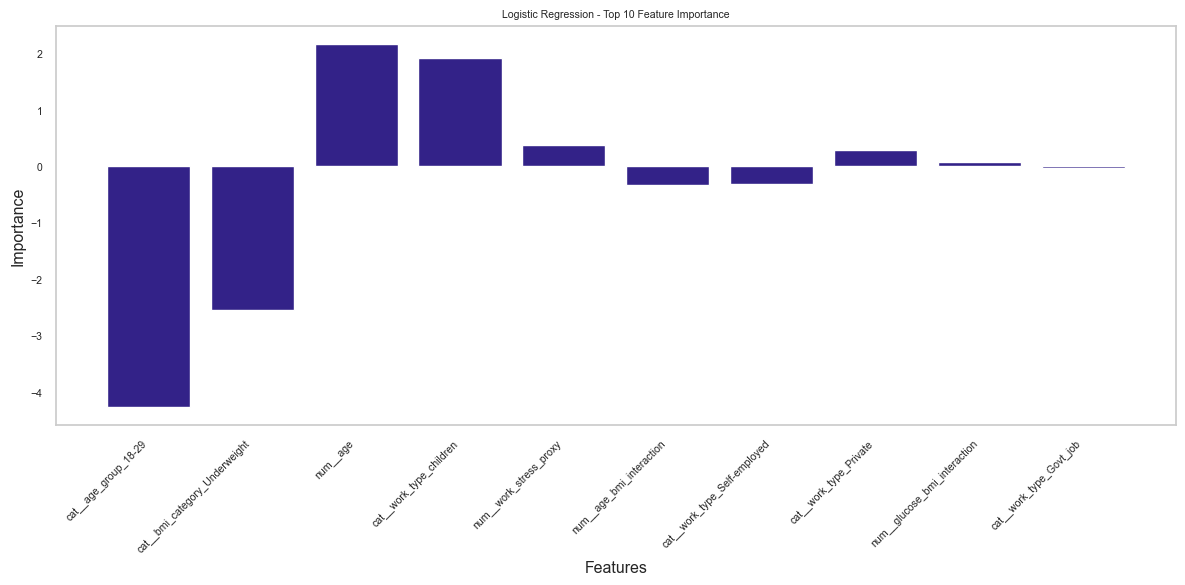


Logistic Regression - Top 10 Important Features:
                         feature  importance
9           cat__age_group_18-29   -4.263092
8  cat__bmi_category_Underweight   -2.544351
0                       num__age    2.171504
7        cat__work_type_children    1.911298
1         num__work_stress_proxy    0.383936
2       num__age_bmi_interaction   -0.324640
6   cat__work_type_Self-employed   -0.317126
5         cat__work_type_Private    0.292777
3   num__glucose_bmi_interaction    0.082979
4        cat__work_type_Govt_job   -0.024830


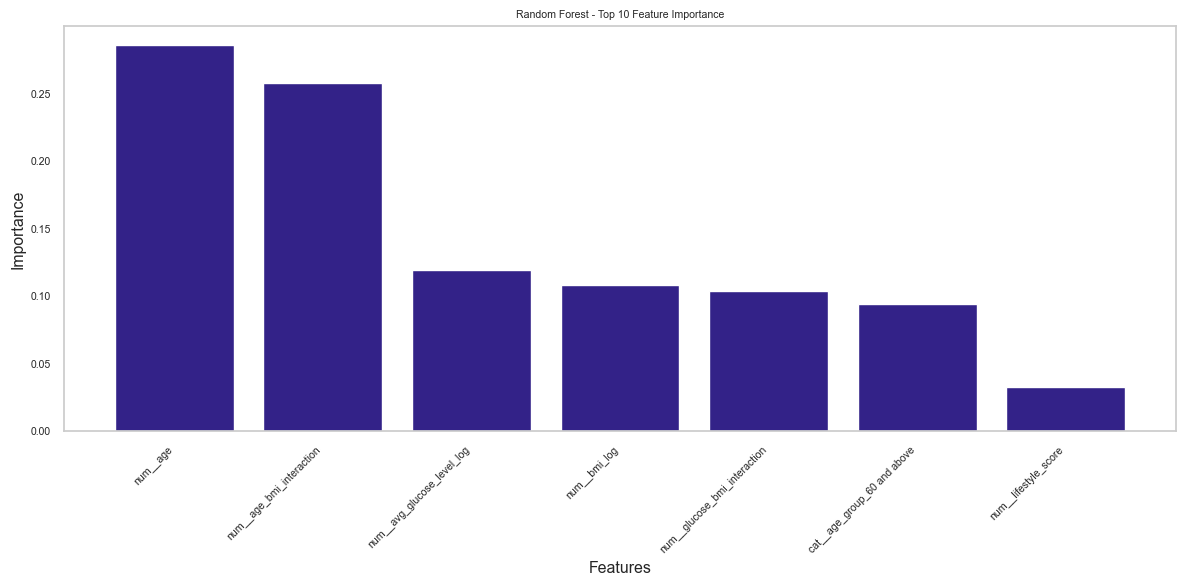


Random Forest - Top 10 Important Features:
                        feature  importance
0                      num__age    0.285589
4      num__age_bmi_interaction    0.257562
1    num__avg_glucose_level_log    0.118937
2                  num__bmi_log    0.107874
5  num__glucose_bmi_interaction    0.103626
6   cat__age_group_60 and above    0.094068
3          num__lifestyle_score    0.032344


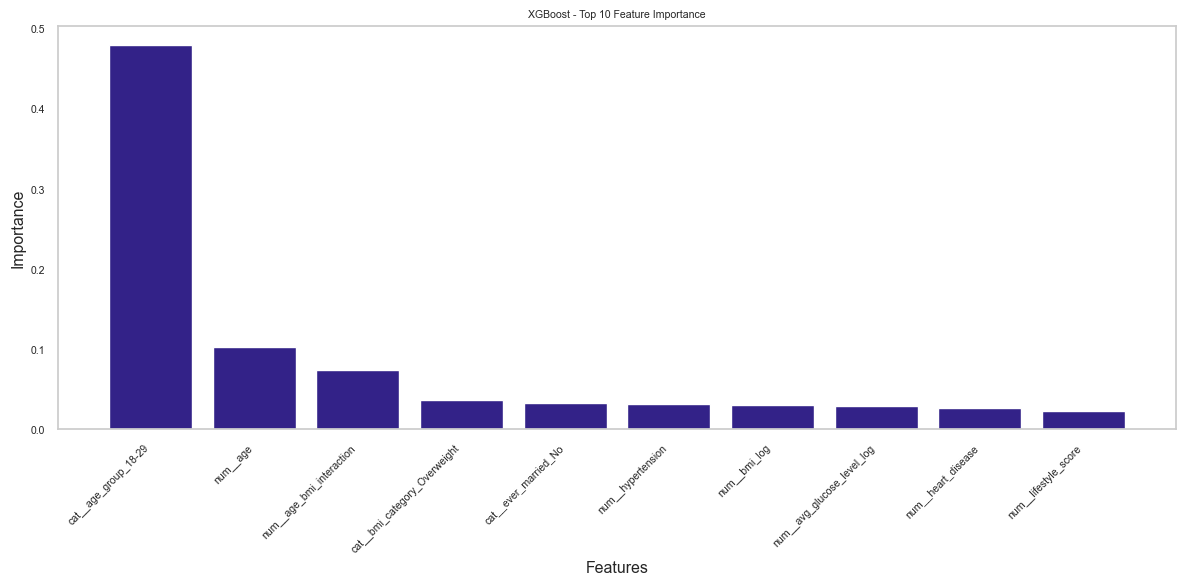


XGBoost - Top 10 Important Features:
                         feature  importance
14          cat__age_group_18-29    0.479703
0                       num__age    0.102130
8       num__age_bmi_interaction    0.073921
13  cat__bmi_category_Overweight    0.036979
11          cat__ever_married_No    0.032266
1              num__hypertension    0.030991
4                   num__bmi_log    0.030174
3     num__avg_glucose_level_log    0.029121
2             num__heart_disease    0.026209
5           num__lifestyle_score    0.023040


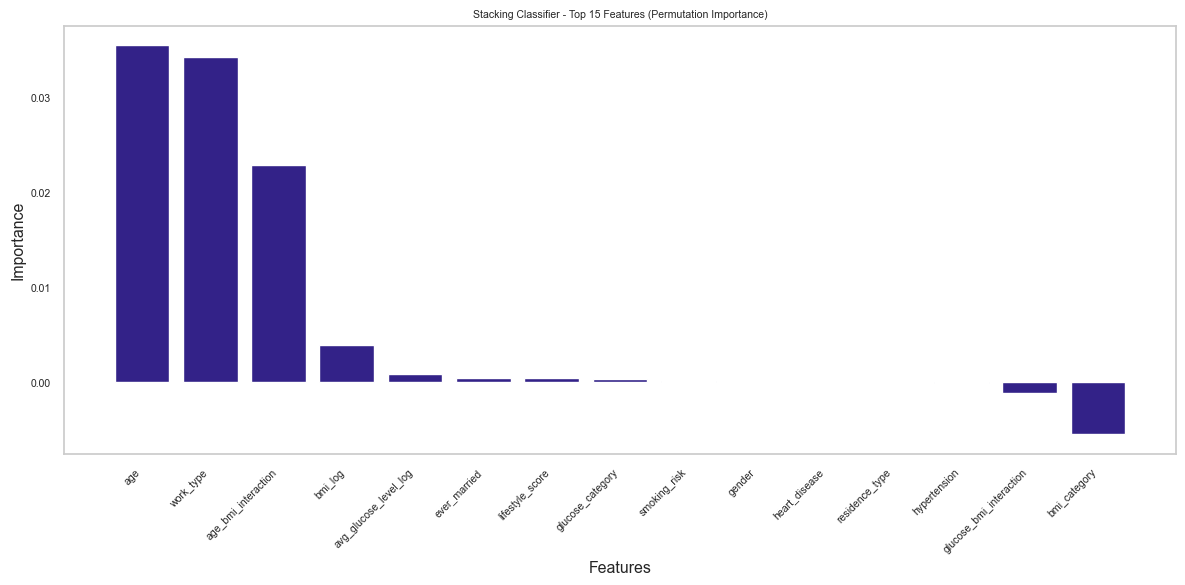


Stacking Classifier - Top 15 Important Features (Permutation Importance):
                    feature  importance
1                       age    0.035460
5                 work_type    0.034188
15      age_bmi_interaction    0.022779
8                   bmi_log    0.003914
7     avg_glucose_level_log    0.000822
4              ever_married    0.000391
12          lifestyle_score    0.000391
11         glucose_category    0.000274
14             smoking_risk    0.000137
0                    gender    0.000020
3             heart_disease    0.000020
6            residence_type    0.000000
2              hypertension   -0.000098
16  glucose_bmi_interaction   -0.001174
9              bmi_category   -0.005499


In [58]:
# 1. Analyze the meta-classifier
meta_classifier = best_model.final_estimator_
meta_feature_importance = pd.DataFrame({
    'feature': ['LR', 'RF', 'XGB'],
    'importance': meta_classifier.coef_[0]
})
meta_feature_importance = meta_feature_importance.sort_values('importance', ascending=False)

# Plot meta-classifier feature importance
plt.figure(figsize=(10, 6))
plt.bar(meta_feature_importance['feature'], meta_feature_importance['importance'])
plt.title('Meta-classifier Feature Importance')
plt.xlabel('Base Models')
plt.ylabel('Coefficient Value')
plt.show()

# 2. Analyze base models
base_models = best_model.estimators_
base_model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
for model, name in zip(base_models, base_model_names):
    if name == 'Logistic Regression':
        # For Logistic Regression
        feature_names = model.named_steps['preprocessor'].get_feature_names_out()
        selected_features = model.named_steps['feature_selection'].get_support()
        coef = model.named_steps['model'].coef_[0]
        
        feature_importance = pd.DataFrame({
            'feature': feature_names[selected_features],
            'importance': coef
        })
        feature_importance = feature_importance.sort_values('importance', key=abs, ascending=False)
        
    elif name == 'Random Forest':
        # For Random Forest
        feature_names = model.named_steps['preprocessor'].get_feature_names_out()
        selected_features = model.named_steps['feature_selection'].get_support()
        importances = model.named_steps['model'].feature_importances_
        
        feature_importance = pd.DataFrame({
            'feature': feature_names[selected_features],
            'importance': importances
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
    elif name == 'XGBoost':
        # For XGBoost
        feature_names = model.named_steps['preprocessor'].get_feature_names_out()
        selected_features = model.named_steps['feature_selection'].get_support()
        importances = model.named_steps['model'].feature_importances_
        
        feature_importance = pd.DataFrame({
            'feature': feature_names[selected_features],
            'importance': importances
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # Plot feature importance for each base model
    plt.figure(figsize=(12, 6))
    plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
    plt.title(f'{name} - Top 10 Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{name} - Top 10 Important Features:")
    print(feature_importance.head(10))

# 3. Permutation Importance for the Stacking Classifier
perm_importance = permutation_importance(best_model, X_model, y_model, n_repeats=10, random_state=RANDOM_STATE)

feature_names = X_model.columns
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
})
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 6))
plt.bar(perm_importance_df['feature'][:15], perm_importance_df['importance'][:15])
plt.title('Stacking Classifier - Top 15 Features (Permutation Importance)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nStacking Classifier - Top 15 Important Features (Permutation Importance):")
print(perm_importance_df.head(15))

<div class="findings">
    <h3>Findings</h3>
    <p>Permutation Importance</p>
    <ol>
        <ul>Logistic Regression is the most influential model in the stacking classifier</ul>
        <ul>Age, BMI and work type are the key features to determine the risk of stroke</ul>
        <ul>The 18-29 age group of patients is considered very important for 2 of the 3 models.</ul>
    </ol>
</div>

## Considerations
* Size of the dataset (~5000 patients).
* Logic of the `stroke` label (when it was assigned to the patient).
* Imbalance of stroke and non-stroke patients (5%/95%).
* Recency of the data (2021 or older).
* Data source and validity (unknown).

## Improvements for Future Studies
* Test additional ML models (SVM, LightGBM, etc.).
* Test alternative ensemble methods.
* Hyperparameter tuning with `GridSearchCV` for improved scores (at a higher computational cost).
* For the super-purist approach, incorporate feature additions into the models' pipeline, instead of doing it on the dataset explicitly.